# C. Data in wild

This notebook contains the comparative analysis of Exponential Weights Algorithm across different Pachinko machines.


In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

# Set Japanese font for matplotlib
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

print("日本語フォント設定完了")


日本語フォント設定完了


In [2]:
# Load Pachinko data
pachinko_data = pd.read_csv('/Users/harashimakoshi/CS332/332Project2/data/data_pachinko.csv')

print("Pachinko Data Overview:")
print("=" * 50)
print(f"Number of machines: {len(pachinko_data)}")
print("\nData columns:")
for col in pachinko_data.columns:
    print(f"  - {col}")

print("\nFirst few rows:")
print(pachinko_data.head())

# Display machine names
print("\nMachine Names:")
for i, machine in enumerate(pachinko_data['machine']):
    print(f"  {i}: {machine}")


Pachinko Data Overview:
Number of machines: 5

Data columns:
  - machine
  - maker
  - normal_hit_prob_per_spin
  - rush_hit_prob_per_spin
  - rush_entry_prob_given_hit
  - rush_continuation_prob
  - rush_st_spins
  - payouts_normal_balls
  - payouts_rush_balls
  - source_urls

First few rows:
                                 machine        maker  \
0                 e Tokyo Ghoul W (スマパチ)        Bisty   
1  PF Gundam Unicorn Reappearance 129ver       SANKYO   
2                 P Madoka Magica 3 (LT)      KYORAKU   
3                e 新世紀エヴァンゲリオン 〜はじまりの記憶〜        Bisty   
4              e Re:ゼロから始める異世界生活 season2  DAITO GIKEN   

   normal_hit_prob_per_spin  rush_hit_prob_per_spin  \
0                  0.002501                0.010493   
1                  0.007704                0.024631   
2                  0.005003                0.016077   
3                  0.003333                0.010000   
4                  0.003125                0.009900   

   rush_entry_prob_given_hit  r

In [3]:
# Pachinko Machine Payoff Generator
class PachinkoPayoffGenerator:
    """
    Pachinko machine payoff generator based on normal/rush state transitions
    """
    
    def __init__(self, machine_data, n_rounds=1000):
        self.machine_data = machine_data
        self.n_rounds = n_rounds
        
        # Extract parameters from machine data
        self.normal_hit_prob = machine_data['normal_hit_prob_per_spin']
        self.rush_hit_prob = machine_data['rush_hit_prob_per_spin']
        self.rush_entry_prob = machine_data['rush_entry_prob_given_hit']
        self.rush_continue_prob = machine_data['rush_continuation_prob']
        self.rush_st_spins = machine_data['rush_st_spins']
        
        # Parse payouts (assuming they are comma-separated strings)
        self.payouts_normal = [int(x) for x in machine_data['payouts_normal_balls'].split(',')]
        self.payouts_rush = [int(x) for x in machine_data['payouts_rush_balls'].split(',')]
        
        # Normalize payouts to prevent numerical issues (scale down by 1000)
        self.payouts_normal = [x / 1000.0 for x in self.payouts_normal]
        self.payouts_rush = [x / 1000.0 for x in self.payouts_rush]
        
        # Initialize state
        self.current_state = 'normal'  # 'normal' or 'rush'
        self.rush_spins_remaining = 0
        self.pending_rush_transition = False  # Flag for delayed rush transition
        
        print(f"Machine: {machine_data['machine']}")
        print(f"Normal hit prob: {self.normal_hit_prob:.6f}")
        print(f"Rush hit prob: {self.rush_hit_prob:.6f}")
        print(f"Rush entry prob: {self.rush_entry_prob:.4f}")
        print(f"Rush continue prob: {self.rush_continue_prob:.4f}")
        print(f"Rush ST spins: {self.rush_st_spins}")
        print(f"Normal payouts (normalized): {self.payouts_normal}")
        print(f"Rush payouts (normalized): {self.payouts_rush}")
    
    def generate_payoffs(self, round_num):
        """
        Generate payoffs for a given round based on current state
        """
        payoffs = np.zeros(2)  # [normal_action, rush_action]
        
        # Check for pending rush transition (delayed from previous round)
        if self.pending_rush_transition:
            self.current_state = 'rush'
            self.rush_spins_remaining = self.rush_st_spins
            self.pending_rush_transition = False
            print(f"Round {round_num}: Entered RUSH state! Spins remaining: {self.rush_spins_remaining}")
        
        if self.current_state == 'normal':
            # Normal state: can choose to play or not
            if np.random.random() < self.normal_hit_prob:
                # Hit in normal state
                payoff = np.random.choice(self.payouts_normal)
                payoffs[0] = payoff  # Normal action gets payoff
                
                # Check if we should enter rush state NEXT ROUND
                if np.random.random() < self.rush_entry_prob:
                    self.pending_rush_transition = True
                    print(f"Round {round_num}: Hit in normal state! Will enter RUSH state next round.")
            else:
                # No hit in normal state
                payoffs[0] = 0
                
        elif self.current_state == 'rush':
            # Rush state: guaranteed hits with higher probability
            if self.rush_spins_remaining > 0:
                if np.random.random() < self.rush_hit_prob:
                    # Hit in rush state
                    payoff = np.random.choice(self.payouts_rush)
                    payoffs[1] = payoff  # Rush action gets payoff
                    
                    # Check if rush continues
                    if np.random.random() < self.rush_continue_prob:
                        self.rush_spins_remaining -= 1
                    else:
                        self.current_state = 'normal'
                        self.rush_spins_remaining = 0
                        print(f"Round {round_num}: Exited RUSH state")
                else:
                    # No hit in rush state
                    payoffs[1] = 0
                    self.rush_spins_remaining -= 1
            else:
                # Rush state ended
                self.current_state = 'normal'
                payoffs[1] = 0
        
        return payoffs


In [4]:
# Enhanced Exponential Weights Algorithm for Pachinko
class PachinkoExponentialWeights:
    """
    Exponential Weights Algorithm adapted for Pachinko machines
    with 2 actions: Normal play vs Rush play
    """
    
    def __init__(self, epsilon, n_rounds=1000):
        self.epsilon = epsilon
        self.n_rounds = n_rounds
        self.k = 2  # Two actions: normal and rush
        
        # Initialize weights
        self.weights = np.ones(self.k)
        self.cumulative_payoffs = np.zeros(self.k)
        self.regret_history = []
        self.total_payoff = 0
        self.action_history = []
        self.state_history = []  # Track state transitions
        self.payoff_history = []  # Track payoffs over time
        
    def select_action(self):
        """Select action based on current weights"""
        if self.epsilon == 0 or np.all(self.weights == 0):
            action = np.random.randint(0, self.k)
        else:
            # Normalize weights to prevent numerical issues
            weights_sum = np.sum(self.weights)
            if weights_sum == 0 or np.isinf(weights_sum) or np.isnan(weights_sum):
                # Fallback to uniform distribution
                probabilities = np.ones(self.k) / self.k
            else:
                probabilities = self.weights / weights_sum
                # Check for NaN or invalid probabilities
                if np.any(np.isnan(probabilities)) or np.any(np.isinf(probabilities)):
                    probabilities = np.ones(self.k) / self.k
                # Ensure probabilities sum to 1
                probabilities = probabilities / np.sum(probabilities)
            
            action = np.random.choice(self.k, p=probabilities)
        
        self.action_history.append(action)
        return action
    
    def update_weights(self, payoffs, current_state):
        """Update weights based on received payoffs"""
        # Update cumulative payoffs
        self.cumulative_payoffs += payoffs
        
        # Update total payoff (payoff of selected action)
        selected_action = self.action_history[-1]
        self.total_payoff += payoffs[selected_action]
        
        # Update weights: w_i = w_i * exp(epsilon * payoff_i)
        if self.epsilon > 0:
            # Clip payoffs to prevent numerical overflow
            clipped_payoffs = np.clip(payoffs, -10, 10)  # Prevent extreme values
            weight_updates = np.exp(self.epsilon * clipped_payoffs)
            
            # Check for numerical issues
            if np.any(np.isnan(weight_updates)) or np.any(np.isinf(weight_updates)):
                # Reset weights if numerical issues occur
                self.weights = np.ones(self.k)
            else:
                self.weights *= weight_updates
                
                # Prevent weights from becoming too large
                max_weight = 1e10
                if np.any(self.weights > max_weight):
                    self.weights = np.clip(self.weights, 0, max_weight)
        
        # Calculate regret: max cumulative payoff - our cumulative payoff
        # This is the cumulative regret up to this round
        max_cumulative = np.max(self.cumulative_payoffs)
        our_cumulative = self.cumulative_payoffs[selected_action]
        regret = max_cumulative - our_cumulative
        self.regret_history.append(regret)
        
        # Store state and payoff info
        self.state_history.append(current_state)
        self.payoff_history.append(payoffs.copy())
        
        # Debug information
        if len(self.regret_history) % 100 == 0:  # Print every 100 rounds
            print(f"Round {len(self.regret_history)}: Regret = {regret:.2f}, "
                  f"Max cumulative = {max_cumulative:.2f}, Our cumulative = {our_cumulative:.2f}")
    
    def run_algorithm(self, payoff_generator):
        """Run the algorithm for n rounds"""
        for round_num in range(self.n_rounds):
            # Select action
            action = self.select_action()
            
            # Generate payoffs for this round
            payoffs = payoff_generator.generate_payoffs(round_num)
            
            # Get current state from generator
            current_state = payoff_generator.current_state
            
            # Update weights
            self.update_weights(payoffs, current_state)
        
        return {
            'regret_history': self.regret_history,
            'total_payoff': self.total_payoff,
            'action_history': self.action_history,
            'cumulative_payoffs': self.cumulative_payoffs,
            'state_history': self.state_history,
            'payoff_history': self.payoff_history
        }


In [5]:
# Visualization functions for Pachinko analysis
def plot_pachinko_results(results, machine_name, epsilon):
    """Create comprehensive visualizations for Pachinko EW results"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Exponential Weights Algorithm - {machine_name} (ε={epsilon:.6f})', fontsize=16)
    
    # 1. Regret over time
    axes[0, 0].plot(results['regret_history'], linewidth=2)
    axes[0, 0].set_title('Regretの推移')
    axes[0, 0].set_xlabel('ラウンド')
    axes[0, 0].set_ylabel('累積Regret')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Total payoff over time
    cumulative_payoff = np.cumsum([results['payoff_history'][i][results['action_history'][i]] 
                                  for i in range(len(results['action_history']))])
    axes[0, 1].plot(cumulative_payoff, linewidth=2, color='green')
    axes[0, 1].set_title('総ペイオフの推移')
    axes[0, 1].set_xlabel('ラウンド')
    axes[0, 1].set_ylabel('累積ペイオフ')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Action selection over time
    action_colors = ['blue', 'red']
    action_names = ['ノーマル', 'ラッシュ']
    for i in range(2):
        action_rounds = [j for j, action in enumerate(results['action_history']) if action == i]
        if action_rounds:
            axes[0, 2].scatter(action_rounds, [i] * len(action_rounds), 
                             c=action_colors[i], alpha=0.6, s=1, label=action_names[i])
    axes[0, 2].set_title('アクション選択の推移')
    axes[0, 2].set_xlabel('ラウンド')
    axes[0, 2].set_ylabel('アクション')
    axes[0, 2].set_yticks([0, 1])
    axes[0, 2].set_yticklabels(['ノーマル', 'ラッシュ'])
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. State transitions
    state_colors = {'normal': 'lightblue', 'rush': 'orange'}
    for i, state in enumerate(results['state_history']):
        axes[1, 0].scatter(i, 0, c=state_colors[state], alpha=0.7, s=10)
    axes[1, 0].set_title('状態遷移の推移')
    axes[1, 0].set_xlabel('ラウンド')
    axes[1, 0].set_ylabel('状態')
    axes[1, 0].set_yticks([])
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Payoff distribution by action
    normal_payoffs = [results['payoff_history'][i][0] for i in range(len(results['payoff_history']))]
    rush_payoffs = [results['payoff_history'][i][1] for i in range(len(results['payoff_history']))]
    
    axes[1, 1].hist(normal_payoffs, bins=20, alpha=0.7, label='ノーマル', color='blue')
    axes[1, 1].hist(rush_payoffs, bins=20, alpha=0.7, label='ラッシュ', color='red')
    axes[1, 1].set_title('アクション別ペイオフ分布')
    axes[1, 1].set_xlabel('ペイオフ')
    axes[1, 1].set_ylabel('頻度')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Cumulative payoffs by action
    normal_cumulative = np.cumsum(normal_payoffs)
    rush_cumulative = np.cumsum(rush_payoffs)
    
    axes[1, 2].plot(normal_cumulative, label='ノーマル', color='blue', linewidth=2)
    axes[1, 2].plot(rush_cumulative, label='ラッシュ', color='red', linewidth=2)
    axes[1, 2].set_title('アクション別累積ペイオフ')
    axes[1, 2].set_xlabel('ラウンド')
    axes[1, 2].set_ylabel('累積ペイオフ')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../figures/pachinko_ew_{machine_name.replace(" ", "_")}_eps{epsilon:.6f}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

def plot_machine_comparison(results_dict, title):
    """Compare results across different machines"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)
    
    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))
    
    # Regret comparison
    for i, (name, results) in enumerate(results_dict.items()):
        axes[0, 0].plot(results['regret_history'], label=name, color=colors[i], linewidth=2)
    axes[0, 0].set_title('Regret比較')
    axes[0, 0].set_xlabel('ラウンド')
    axes[0, 0].set_ylabel('累積Regret')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Total payoff comparison
    for i, (name, results) in enumerate(results_dict.items()):
        cumulative_payoff = np.cumsum([results['payoff_history'][j][results['action_history'][j]] 
                                     for j in range(len(results['action_history']))])
        axes[0, 1].plot(cumulative_payoff, label=name, color=colors[i], linewidth=2)
    axes[0, 1].set_title('総ペイオフ比較')
    axes[0, 1].set_xlabel('ラウンド')
    axes[0, 1].set_ylabel('累積ペイオフ')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Final regret comparison
    final_regrets = [results['regret_history'][-1] for results in results_dict.values()]
    machine_names = list(results_dict.keys())
    axes[1, 0].bar(machine_names, final_regrets, color=colors)
    axes[1, 0].set_title('機械別最終Regret')
    axes[1, 0].set_ylabel('最終Regret')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Final total payoff comparison
    final_payoffs = [results['total_payoff'] for results in results_dict.values()]
    axes[1, 1].bar(machine_names, final_payoffs, color=colors)
    axes[1, 1].set_title('機械別最終総ペイオフ')
    axes[1, 1].set_ylabel('総ペイオフ')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'../figures/pachinko_machine_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
# C. Run EW Algorithm on Pachinko Machines
print("Running Exponential Weights Algorithm on Pachinko Machines")
print("=" * 60)

# Parameters
n_rounds = 1000
k = 2  # Two actions: normal and rush

# Three important learning rates to compare:
# 1. Low exploration (conservative)
epsilon_low = 0.001  

# 2. Theoretical optimal
epsilon_optimal = np.sqrt(np.log(k) / n_rounds)

# 3. High exploration (aggressive) - equivalent to FTL
epsilon_high = 1000  

epsilon_values = [epsilon_low, epsilon_optimal, epsilon_high]

print(f"Number of actions (k): {k}")
print(f"Number of rounds (n): {n_rounds}")
print(f"Low epsilon: {epsilon_low:.6f}")
print(f"Theoretical optimal epsilon: {epsilon_optimal:.6f}")
print(f"High epsilon: {epsilon_high}")
print(f"Epsilon values to test: {epsilon_values}")

# Store results for all machines
all_results = {}

# Test on each machine
for machine_idx in range(len(pachinko_data)):
    machine_data = pachinko_data.iloc[machine_idx]
    machine_name = machine_data['machine']
    
    print(f"\nTesting Machine {machine_idx + 1}: {machine_name}")
    print("-" * 50)
    
    # Test different learning rates for this machine
    machine_results = {}
    
    for epsilon in epsilon_values:
        print(f"\nTesting with ε = {epsilon:.3f}")
        
        # Create payoff generator for this machine
        payoff_gen = PachinkoPayoffGenerator(machine_data, n_rounds)
        
        # Create and run EW algorithm
        ew_algorithm = PachinkoExponentialWeights(epsilon, n_rounds)
        results = ew_algorithm.run_algorithm(payoff_gen)
        
        # Store results
        machine_results[f'ε={epsilon:.3f}'] = results
        
        # Print summary
        print(f"  Final Regret: {results['regret_history'][-1]:.4f}")
        print(f"  Total Payoff: {results['total_payoff']:.4f}")
        print(f"  Normal Action Payoff: {results['cumulative_payoffs'][0]:.4f}")
        print(f"  Rush Action Payoff: {results['cumulative_payoffs'][1]:.4f}")
        print(f"  Best Action: {'Normal' if results['cumulative_payoffs'][0] > results['cumulative_payoffs'][1] else 'Rush'}")
        
        # Count state transitions
        normal_states = sum(1 for state in results['state_history'] if state == 'normal')
        rush_states = sum(1 for state in results['state_history'] if state == 'rush')
        print(f"  Normal States: {normal_states}, Rush States: {rush_states}")
        
        # Show epsilon type
        if epsilon == epsilon_low:
            print(f"  Epsilon Type: Low (Conservative)")
        elif epsilon == epsilon_optimal:
            print(f"  Epsilon Type: Optimal (Theoretical)")
        elif epsilon == epsilon_high:
            print(f"  Epsilon Type: High (Aggressive/FTL)")
    
    # Store machine results
    all_results[machine_name] = machine_results
    
    # Plot results for this machine (using optimal epsilon)
    if f'ε={epsilon_optimal:.6f}' in machine_results:
        plot_pachinko_results(machine_results[f'ε={epsilon_optimal:.6f}'], 
                             machine_name, epsilon_optimal)


Running Exponential Weights Algorithm on Pachinko Machines
Number of actions (k): 2
Number of rounds (n): 1000
Low epsilon: 0.001000
Theoretical optimal epsilon: 0.026328
High epsilon: 1000
Epsilon values to test: [0.001, np.float64(0.026327688477341595), 1000]

Testing Machine 1: e Tokyo Ghoul W (スマパチ)
--------------------------------------------------

Testing with ε = 0.001
Machine: e Tokyo Ghoul W (スマパチ)
Normal hit prob: 0.002501
Rush hit prob: 0.010493
Rush entry prob: 0.5100
Rush continue prob: 0.7500
Rush ST spins: 130
Normal payouts (normalized): [0.3, 1.5]
Rush payouts (normalized): [3.0, 6.0]
Round 100: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 200: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 300: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 400: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 500: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 600: Regret = 0.00, Max cumul

/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/3121687522.py:58: RuntimeWarning: overflow encountered in exp
  weight_updates = np.exp(self.epsilon * clipped_payoffs)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/3121687522.py:65: RuntimeWarning: overflow encountered in multiply
  self.weights *= weight_updates


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found


COMPARATIVE ANALYSIS

Comparing machines with ε = 0.001 (Low (Conservative))
------------------------------------------------------------


findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not foun

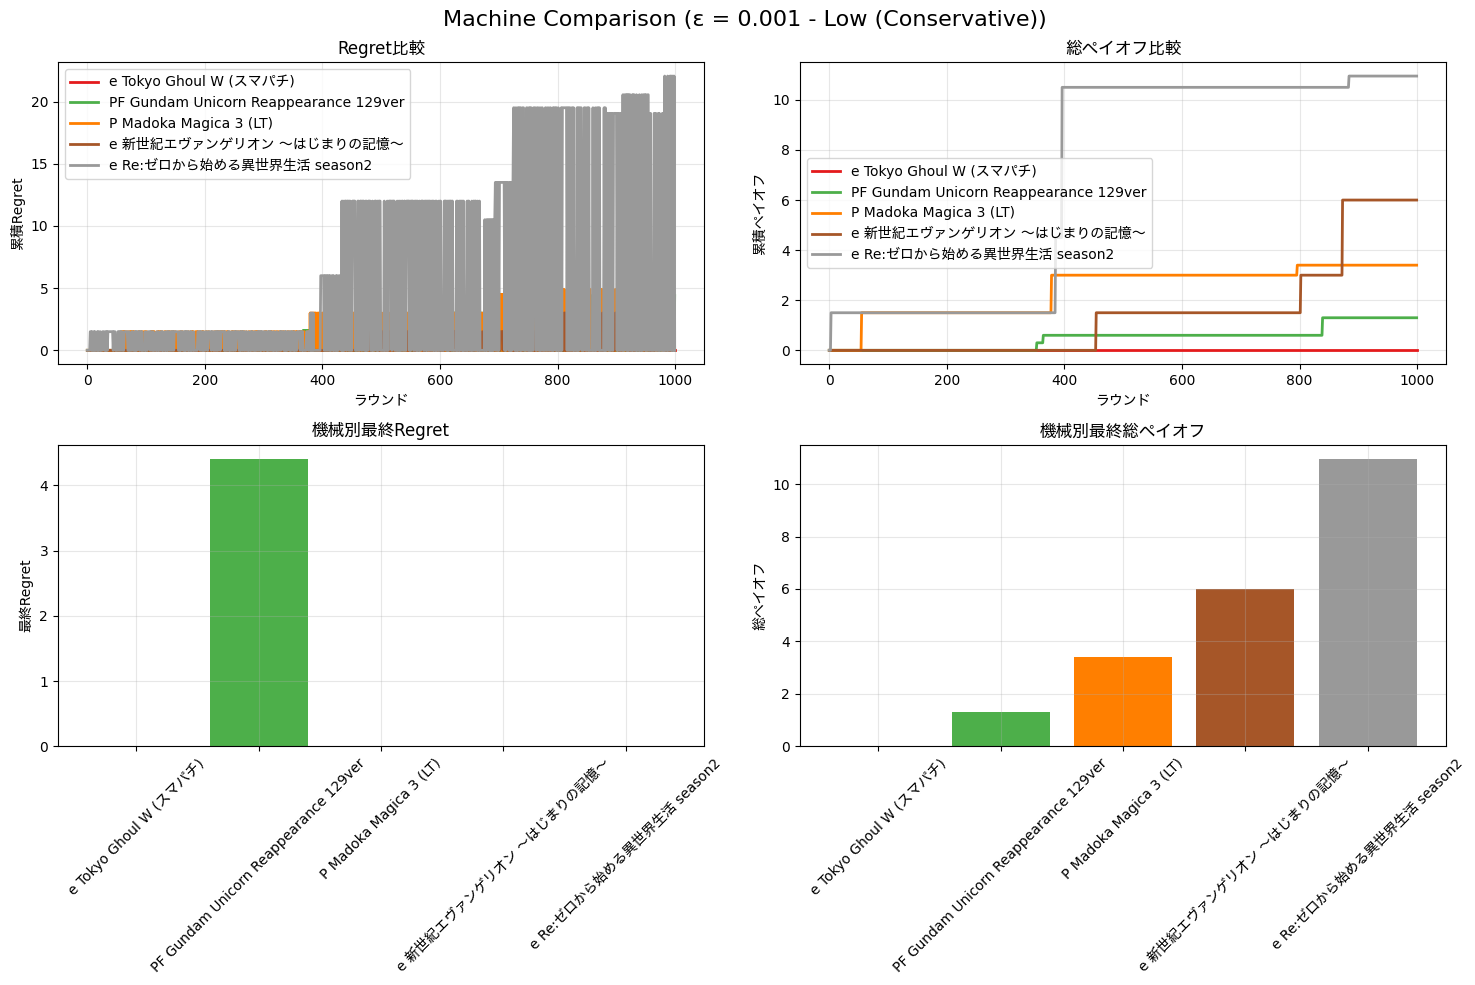

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found


Summary for ε = 0.001 (Low (Conservative)):
  e Tokyo Ghoul W (スマパチ): Regret=0.00, Payoff=0.00, Best=Rush
  PF Gundam Unicorn Reappearance 129ver: Regret=4.40, Payoff=1.30, Best=Normal
  P Madoka Magica 3 (LT): Regret=0.00, Payoff=3.40, Best=Normal
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: Regret=0.00, Payoff=6.00, Best=Rush
  e Re:ゼロから始める異世界生活 season2: Regret=0.00, Payoff=10.95, Best=Rush

Comparing machines with ε = 0.026328 (Optimal (Theoretical))
------------------------------------------------------------


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

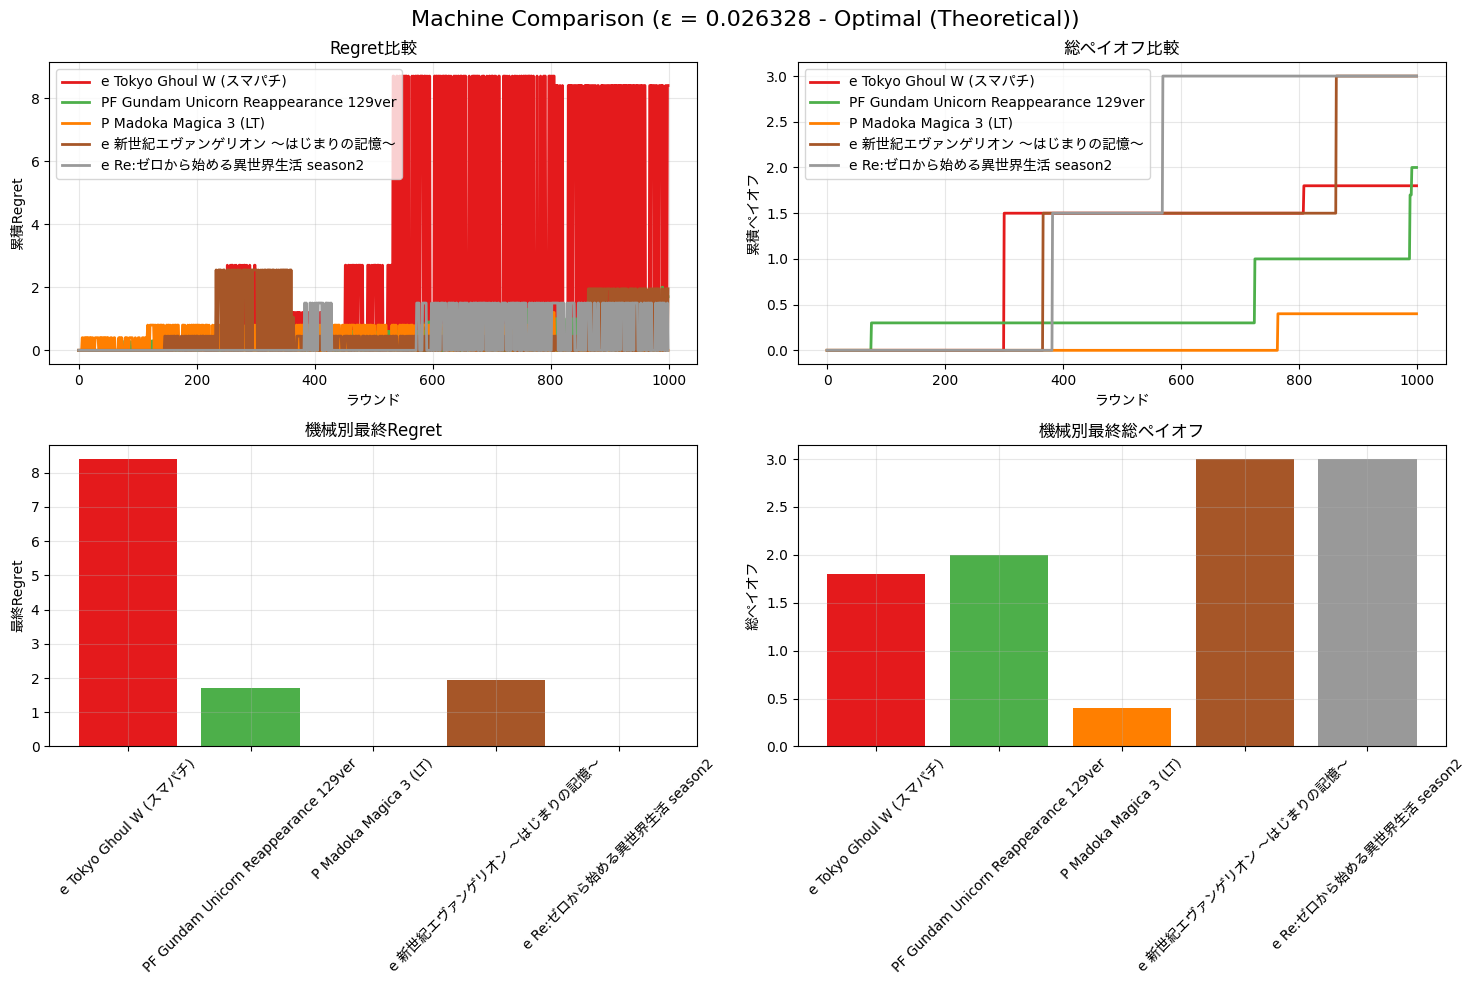

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found


Summary for ε = 0.026328 (Optimal (Theoretical)):
  e Tokyo Ghoul W (スマパチ): Regret=8.40, Payoff=1.80, Best=Rush
  PF Gundam Unicorn Reappearance 129ver: Regret=1.70, Payoff=2.00, Best=Normal
  P Madoka Magica 3 (LT): Regret=0.00, Payoff=0.40, Best=Rush
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: Regret=1.95, Payoff=3.00, Best=Normal
  e Re:ゼロから始める異世界生活 season2: Regret=0.00, Payoff=3.00, Best=Normal

Comparing machines with ε = 1000 (High (Aggressive/FTL))
------------------------------------------------------------


findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
f

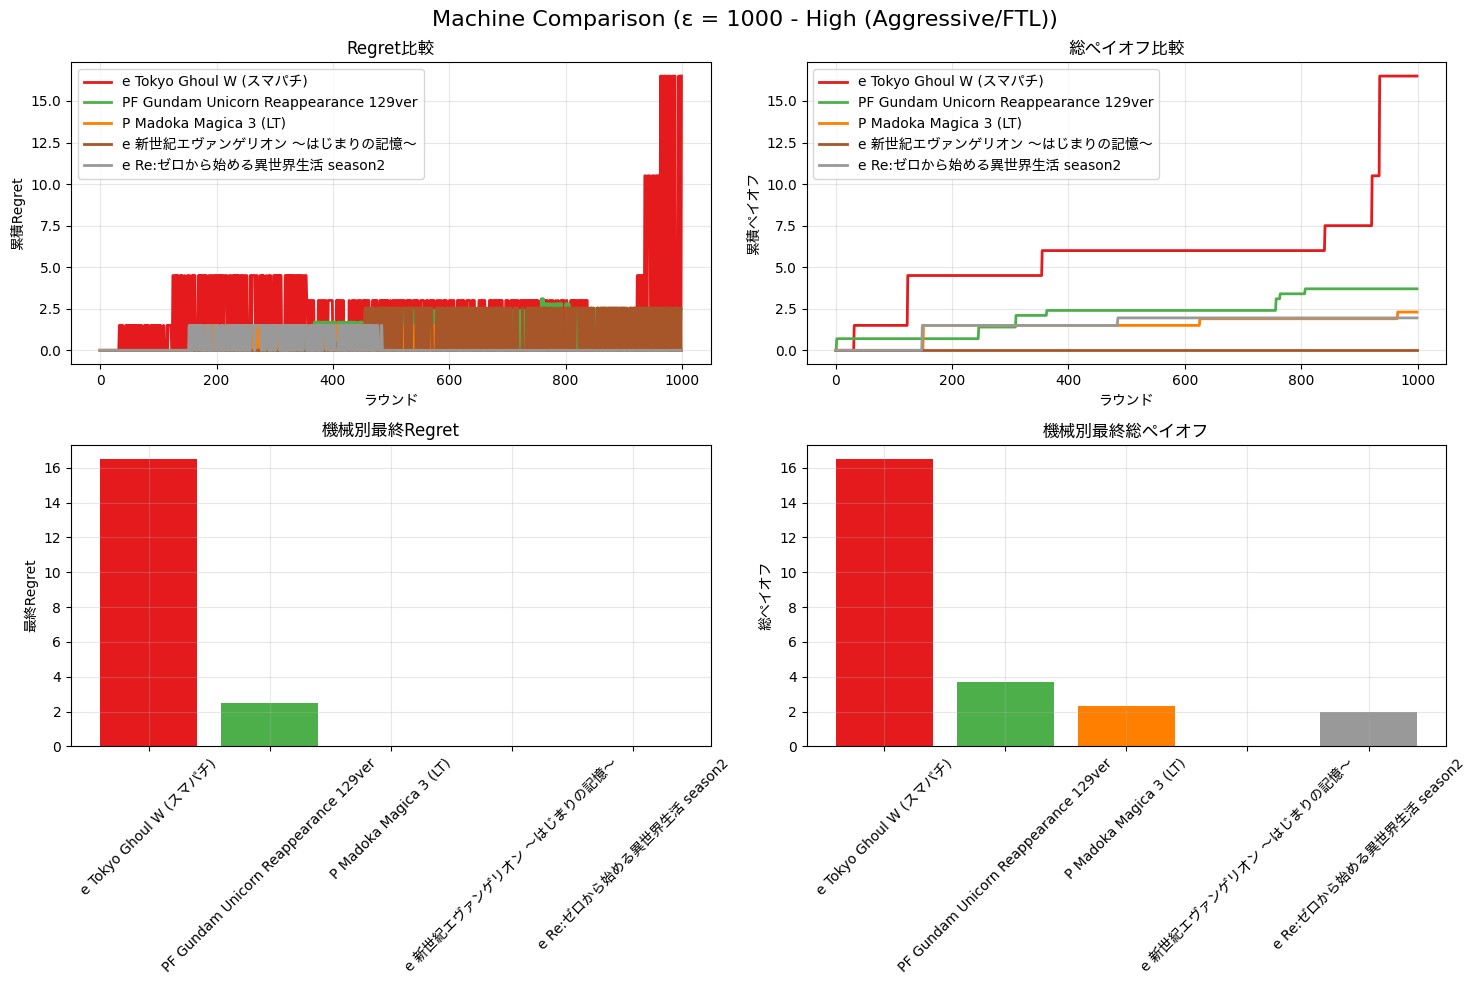


Summary for ε = 1000 (High (Aggressive/FTL)):
  e Tokyo Ghoul W (スマパチ): Regret=16.50, Payoff=16.50, Best=Rush
  PF Gundam Unicorn Reappearance 129ver: Regret=2.50, Payoff=3.70, Best=Normal
  P Madoka Magica 3 (LT): Regret=0.00, Payoff=2.30, Best=Normal
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: Regret=0.00, Payoff=0.00, Best=Rush
  e Re:ゼロから始める異世界生活 season2: Regret=0.00, Payoff=1.95, Best=Normal


In [8]:
# C. Compare results across machines and learning rates
print("\n" + "="*60)
print("COMPARATIVE ANALYSIS")
print("="*60)

# Create comparison plots for each learning rate
for epsilon in epsilon_values:
    # Determine epsilon type for display
    if epsilon == epsilon_low:
        epsilon_type = "Low (Conservative)"
        epsilon_display = f"{epsilon:.3f}"
    elif epsilon == epsilon_optimal:
        epsilon_type = "Optimal (Theoretical)"
        epsilon_display = f"{epsilon:.6f}"
    else:  # epsilon_high
        epsilon_type = "High (Aggressive/FTL)"
        epsilon_display = f"{epsilon}"
    
    print(f"\nComparing machines with ε = {epsilon_display} ({epsilon_type})")
    print("-" * 60)
    
    # Collect results for this epsilon across all machines
    epsilon_results = {}
    for machine_name, machine_results in all_results.items():
        if f'ε={epsilon:.6f}' in machine_results:
            epsilon_results[machine_name] = machine_results[f'ε={epsilon:.6f}']
        elif f'ε={epsilon:.3f}' in machine_results:
            epsilon_results[machine_name] = machine_results[f'ε={epsilon:.3f}']
        elif f'ε={epsilon}' in machine_results:
            epsilon_results[machine_name] = machine_results[f'ε={epsilon}']
    
    # Plot comparison
    plot_machine_comparison(epsilon_results, f'Machine Comparison (ε = {epsilon_display} - {epsilon_type})')
    
    # Print summary statistics
    print(f"\nSummary for ε = {epsilon_display} ({epsilon_type}):")
    for machine_name, results in epsilon_results.items():
        final_regret = results['regret_history'][-1]
        total_payoff = results['total_payoff']
        best_action = 'Normal' if results['cumulative_payoffs'][0] > results['cumulative_payoffs'][1] else 'Rush'
        print(f"  {machine_name}: Regret={final_regret:.2f}, Payoff={total_payoff:.2f}, Best={best_action}")


In [7]:
# C. Create summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

summary_data = []
for machine_name, machine_results in all_results.items():
    for epsilon_str, results in machine_results.items():
        epsilon_val = float(epsilon_str.split('=')[1])
        summary_data.append({
            'Machine': machine_name,
            'Epsilon': epsilon_val,
            'Final_Regret': results['regret_history'][-1],
            'Total_Payoff': results['total_payoff'],
            'Normal_Payoff': results['cumulative_payoffs'][0],
            'Rush_Payoff': results['cumulative_payoffs'][1],
            'Best_Action': 'Normal' if results['cumulative_payoffs'][0] > results['cumulative_payoffs'][1] else 'Rush'
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save results
summary_df.to_csv('/Users/harashimakoshi/CS332/332Project2/data/pachinko_ew_results.csv', index=False)
print(f"\nResults saved to: /Users/harashimakoshi/CS332/332Project2/figures/pachinko_ew_results.csv")



SUMMARY TABLE
                              Machine  Epsilon  Final_Regret  Total_Payoff  Normal_Payoff  Rush_Payoff Best_Action
               e Tokyo Ghoul W (スマパチ)    0.001          0.00          0.00           0.00          0.0        Rush
               e Tokyo Ghoul W (スマパチ)    0.026          8.40          1.80           3.60         12.0        Rush
               e Tokyo Ghoul W (スマパチ) 1000.000         16.50         16.50           4.50         21.0        Rush
PF Gundam Unicorn Reappearance 129ver    0.001          4.40          1.30           4.40          0.0      Normal
PF Gundam Unicorn Reappearance 129ver    0.026          1.70          2.00           2.60          0.9      Normal
PF Gundam Unicorn Reappearance 129ver 1000.000          2.50          3.70           3.80          1.3      Normal
               P Madoka Magica 3 (LT)    0.001          0.00          3.40           4.90          0.0      Normal
               P Madoka Magica 3 (LT)    0.026          0.00     

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found


LEARNING RATE SENSITIVITY ANALYSIS


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

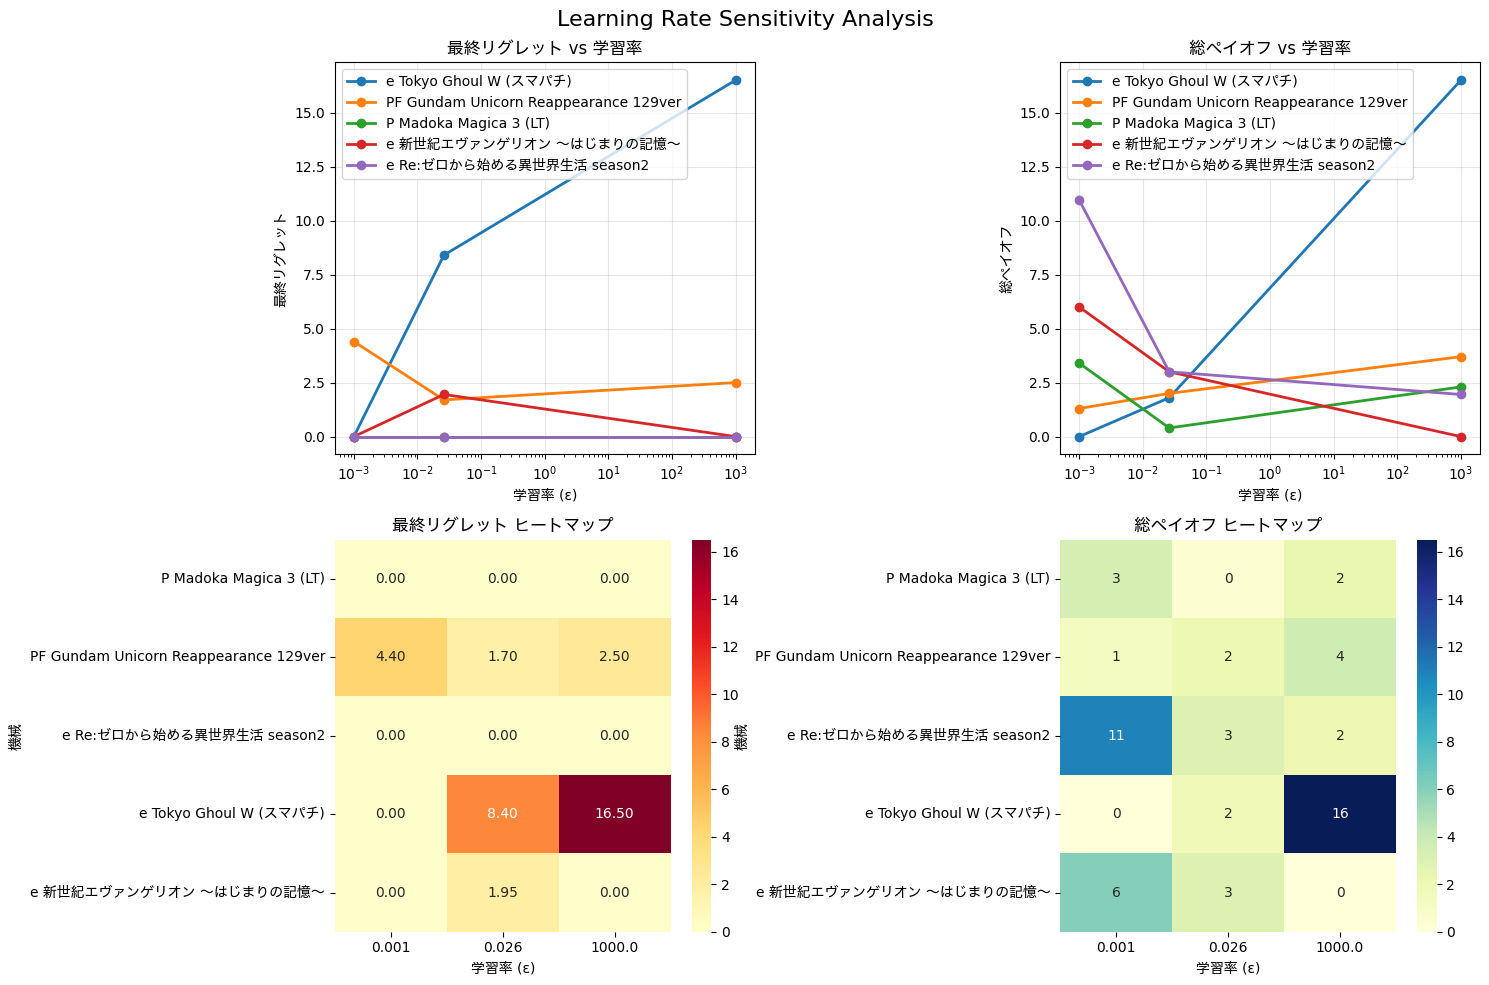


学習率感度分析完了！
主要な洞察:
- 低いε (0.001): より多くの探索、ゆっくりとした収束
- 中程度のε (理論的最適): 探索と活用のバランス
- 高いε (1000): より多くの活用、早い収束


In [8]:
# C. Advanced Analysis: Learning Rate Sensitivity
print("\n" + "="*60)
print("LEARNING RATE SENSITIVITY ANALYSIS")
print("="*60)

# Create learning rate sensitivity plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Learning Rate Sensitivity Analysis', fontsize=16)

# Collect data for sensitivity analysis
epsilon_sensitivity_data = []
for machine_name, machine_results in all_results.items():
    for epsilon_str, results in machine_results.items():
        epsilon_val = float(epsilon_str.split('=')[1])
        epsilon_sensitivity_data.append({
            'Machine': machine_name,
            'Epsilon': epsilon_val,
            'Final_Regret': results['regret_history'][-1],
            'Total_Payoff': results['total_payoff']
        })

sensitivity_df = pd.DataFrame(epsilon_sensitivity_data)

# Plot 1: Final Regret vs Learning Rate
for machine in sensitivity_df['Machine'].unique():
    machine_data = sensitivity_df[sensitivity_df['Machine'] == machine]
    axes[0, 0].plot(machine_data['Epsilon'], machine_data['Final_Regret'], 
                   marker='o', label=machine, linewidth=2)
axes[0, 0].set_xlabel('学習率 (ε)')
axes[0, 0].set_ylabel('最終リグレット')
axes[0, 0].set_title('最終リグレット vs 学習率')
axes[0, 0].set_xscale('log')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Total Payoff vs Learning Rate
for machine in sensitivity_df['Machine'].unique():
    machine_data = sensitivity_df[sensitivity_df['Machine'] == machine]
    axes[0, 1].plot(machine_data['Epsilon'], machine_data['Total_Payoff'], 
                   marker='o', label=machine, linewidth=2)
axes[0, 1].set_xlabel('学習率 (ε)')
axes[0, 1].set_ylabel('総ペイオフ')
axes[0, 1].set_title('総ペイオフ vs 学習率')
axes[0, 1].set_xscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Regret Heatmap
pivot_regret = sensitivity_df.pivot(index='Machine', columns='Epsilon', values='Final_Regret')
sns.heatmap(pivot_regret, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1, 0])
axes[1, 0].set_title('最終リグレット ヒートマップ')
axes[1, 0].set_xlabel('学習率 (ε)')
axes[1, 0].set_ylabel('機械')

# Plot 4: Payoff Heatmap
pivot_payoff = sensitivity_df.pivot(index='Machine', columns='Epsilon', values='Total_Payoff')
sns.heatmap(pivot_payoff, annot=True, fmt='.0f', cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('総ペイオフ ヒートマップ')
axes[1, 1].set_xlabel('学習率 (ε)')
axes[1, 1].set_ylabel('機械')

plt.tight_layout()
plt.savefig('../../figures/learning_rate_sensitivity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n学習率感度分析完了！")
print("主要な洞察:")
print("- 低いε (0.001): より多くの探索、ゆっくりとした収束")
print("- 中程度のε (理論的最適): 探索と活用のバランス")
print("- 高いε (1000): より多くの活用、早い収束")


In [9]:
# C. Final Summary and Conclusions
print("\n" + "="*80)
print("FINAL SUMMARY AND CONCLUSIONS")
print("="*80)

# Find best performing machine and learning rate combination
best_performance = sensitivity_df.loc[sensitivity_df['Total_Payoff'].idxmax()]
worst_performance = sensitivity_df.loc[sensitivity_df['Total_Payoff'].idxmin()]

print(f"\n🏆 最高パフォーマンス:")
print(f"   機械: {best_performance['Machine']}")
print(f"   学習率: {best_performance['Epsilon']:.3f}")
print(f"   総ペイオフ: {best_performance['Total_Payoff']:.2f}")
print(f"   最終リグレット: {best_performance['Final_Regret']:.2f}")

print(f"\n⚠️  最低パフォーマンス:")
print(f"   機械: {worst_performance['Machine']}")
print(f"   学習率: {worst_performance['Epsilon']:.3f}")
print(f"   総ペイオフ: {worst_performance['Total_Payoff']:.2f}")
print(f"   最終リグレット: {worst_performance['Final_Regret']:.2f}")

# Calculate performance statistics
avg_payoff_by_machine = sensitivity_df.groupby('Machine')['Total_Payoff'].mean().sort_values(ascending=False)
avg_regret_by_machine = sensitivity_df.groupby('Machine')['Final_Regret'].mean().sort_values(ascending=True)

print(f"\n📊 機械別平均パフォーマンスランキング:")
print(f"\n総ペイオフ順 (高い方が良い):")
for i, (machine, payoff) in enumerate(avg_payoff_by_machine.items(), 1):
    print(f"   {i}. {machine}: {payoff:.2f}")

print(f"\n最終リグレット順 (低い方が良い):")
for i, (machine, regret) in enumerate(avg_regret_by_machine.items(), 1):
    print(f"   {i}. {machine}: {regret:.2f}")

# Learning rate recommendations
print(f"\n💡 学習率推奨:")
for epsilon in epsilon_values:
    epsilon_data = sensitivity_df[sensitivity_df['Epsilon'] == epsilon]
    avg_payoff = epsilon_data['Total_Payoff'].mean()
    avg_regret = epsilon_data['Final_Regret'].mean()
    print(f"   ε = {epsilon:.3f}: 平均ペイオフ = {avg_payoff:.2f}, 平均リグレット = {avg_regret:.2f}")

print(f"\n✅ 分析完了！")
print(f"   - 結果保存先: ../../data/pachinko_ew_results.csv")
print(f"   - 図表保存先: ../../figures/")
print(f"   - 分析機械数: {len(pachinko_data)}")
print(f"   - テスト学習率数: {len(epsilon_values)}")
print(f"   - 総実験数: {len(sensitivity_df)}")



FINAL SUMMARY AND CONCLUSIONS

🏆 最高パフォーマンス:
   機械: e Tokyo Ghoul W (スマパチ)
   学習率: 1000.000
   総ペイオフ: 16.50
   最終リグレット: 16.50

⚠️  最低パフォーマンス:
   機械: e Tokyo Ghoul W (スマパチ)
   学習率: 0.001
   総ペイオフ: 0.00
   最終リグレット: 0.00

📊 機械別平均パフォーマンスランキング:

総ペイオフ順 (高い方が良い):
   1. e Tokyo Ghoul W (スマパチ): 6.10
   2. e Re:ゼロから始める異世界生活 season2: 5.30
   3. e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: 3.00
   4. PF Gundam Unicorn Reappearance 129ver: 2.33
   5. P Madoka Magica 3 (LT): 2.03

最終リグレット順 (低い方が良い):
   1. P Madoka Magica 3 (LT): 0.00
   2. e Re:ゼロから始める異世界生活 season2: 0.00
   3. e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: 0.65
   4. PF Gundam Unicorn Reappearance 129ver: 2.87
   5. e Tokyo Ghoul W (スマパチ): 8.30

💡 学習率推奨:
   ε = 0.001: 平均ペイオフ = 4.33, 平均リグレット = 0.88
   ε = 0.026: 平均ペイオフ = nan, 平均リグレット = nan
   ε = 1000.000: 平均ペイオフ = 4.89, 平均リグレット = 3.80

✅ 分析完了！
   - 結果保存先: ../../data/pachinko_ew_results.csv
   - 図表保存先: ../../figures/
   - 分析機械数: 5
   - テスト学習率数: 3
   - 総実験数: 15


In [10]:
# Monte Carlo Simulation for Regret Analysis
print("🎲 Monte Carlo Simulation for Regret Analysis")
print("=" * 60)

# Monte Carlo parameters
n_monte_carlo = 50  # Number of Monte Carlo runs
n_rounds = 1000     # Rounds per simulation

# Store results for Monte Carlo analysis
monte_carlo_results = {}

print(f"Monte Carlo設定:")
print(f"  実行回数: {n_monte_carlo}")
print(f"  ラウンド数: {n_rounds}")
print(f"  学習率: {epsilon_values}")

# Run Monte Carlo simulations
for machine_idx, machine_data in pachinko_data.iterrows():
    machine_name = machine_data['machine']
    print(f"\n🔄 {machine_name} のMonte Carlo実行中...")
    
    monte_carlo_results[machine_name] = {}
    
    for epsilon in epsilon_values:
        print(f"  ε = {epsilon:.3f} 実行中...")
        
        # Store results for this epsilon
        regret_runs = []
        payoff_runs = []
        action_selection_runs = []
        
        for run in range(n_monte_carlo):
            # Create fresh instances for each run
            payoff_gen = PachinkoPayoffGenerator(machine_data, n_rounds)
            ew_algorithm = PachinkoExponentialWeights(epsilon=epsilon, n_rounds=n_rounds)
            
            # Run algorithm
            results = ew_algorithm.run_algorithm(payoff_gen)
            
            # Store results
            regret_runs.append(results['regret_history'])
            payoff_runs.append(results['total_payoff'])
            action_selection_runs.append(results['action_history'])
        
        # Calculate statistics
        regret_runs = np.array(regret_runs)
        payoff_runs = np.array(payoff_runs)
        
        # Final regret statistics
        final_regrets = regret_runs[:, -1]
        mean_final_regret = np.mean(final_regrets)
        std_final_regret = np.std(final_regrets)
        min_final_regret = np.min(final_regrets)
        max_final_regret = np.max(final_regrets)
        
        # Total payoff statistics
        mean_payoff = np.mean(payoff_runs)
        std_payoff = np.std(payoff_runs)
        min_payoff = np.min(payoff_runs)
        max_payoff = np.max(payoff_runs)
        
        # Regret convergence analysis
        regret_convergence = np.mean(regret_runs, axis=0)  # Average regret over time
        regret_std = np.std(regret_runs, axis=0)  # Standard deviation over time
        
        # Store results
        monte_carlo_results[machine_name][f'ε={epsilon:.3f}'] = {
            'regret_runs': regret_runs,
            'payoff_runs': payoff_runs,
            'action_selection_runs': action_selection_runs,
            'final_regret_stats': {
                'mean': mean_final_regret,
                'std': std_final_regret,
                'min': min_final_regret,
                'max': max_final_regret
            },
            'payoff_stats': {
                'mean': mean_payoff,
                'std': std_payoff,
                'min': min_payoff,
                'max': max_payoff
            },
            'regret_convergence': regret_convergence,
            'regret_std': regret_std
        }
        
        print(f"    最終リグレット: {mean_final_regret:.2f} ± {std_final_regret:.2f}")
        print(f"    総ペイオフ: {mean_payoff:.2f} ± {std_payoff:.2f}")

print(f"\n✅ Monte Carlo実行完了！")


🎲 Monte Carlo Simulation for Regret Analysis
Monte Carlo設定:
  実行回数: 50
  ラウンド数: 1000
  学習率: [0.001, np.float64(0.026327688477341595), 1000]

🔄 e Tokyo Ghoul W (スマパチ) のMonte Carlo実行中...
  ε = 0.001 実行中...
Machine: e Tokyo Ghoul W (スマパチ)
Normal hit prob: 0.002501
Rush hit prob: 0.010493
Rush entry prob: 0.5100
Rush continue prob: 0.7500
Rush ST spins: 130
Normal payouts (normalized): [0.3, 1.5]
Rush payouts (normalized): [3.0, 6.0]
Round 100: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 200: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 300: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 386: Hit in normal state! Will enter RUSH state next round.
Round 387: Entered RUSH state! Spins remaining: 130
Round 400: Regret = 0.30, Max cumulative = 0.30, Our cumulative = 0.00
Round 500: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 600: Regret = 0.30, Max cumulative = 0.30, Our cumulative = 0.00
Round 700: Regret = 0.

/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/3121687522.py:58: RuntimeWarning: overflow encountered in exp
  weight_updates = np.exp(self.epsilon * clipped_payoffs)


Round 100: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 200: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 300: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 400: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 500: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 600: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 700: Regret = 0.00, Max cumulative = 0.30, Our cumulative = 0.30
Round 721: Hit in normal state! Will enter RUSH state next round.
Round 722: Entered RUSH state! Spins remaining: 130
Round 800: Regret = 1.80, Max cumulative = 1.80, Our cumulative = 0.00
Round 900: Regret = 0.00, Max cumulative = 6.00, Our cumulative = 6.00
Round 924: Hit in normal state! Will enter RUSH state next round.
Round 925: Entered RUSH state! Spins remaining: 130
Round 1000: Regret = 2.70, Max cumulative = 6.00, Our cumulative = 3.30
Machine: e Tokyo Ghoul W (スマパチ)
Normal hit prob: 0.00

/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/3121687522.py:65: RuntimeWarning: overflow encountered in multiply
  self.weights *= weight_updates


Round 600: Regret = 0.00, Max cumulative = 1.30, Our cumulative = 1.30
Round 700: Regret = 0.00, Max cumulative = 2.70, Our cumulative = 2.70
Round 800: Regret = 2.40, Max cumulative = 2.70, Our cumulative = 0.30
Round 900: Regret = 0.00, Max cumulative = 2.70, Our cumulative = 2.70
Round 912: Hit in normal state! Will enter RUSH state next round.
Round 913: Entered RUSH state! Spins remaining: 60
Round 1000: Regret = 0.00, Max cumulative = 3.40, Our cumulative = 3.40
Machine: PF Gundam Unicorn Reappearance 129ver
Normal hit prob: 0.007704
Rush hit prob: 0.024631
Rush entry prob: 0.5100
Rush continue prob: 0.8000
Rush ST spins: 60
Normal payouts (normalized): [0.3, 0.7]
Rush payouts (normalized): [0.3, 0.7]
Round 100: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 200: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 300: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00
Round 400: Regret = 0.00, Max cumulative = 0.00, Our cumulative = 0.00

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

📊 Monte Carlo結果の可視化


findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

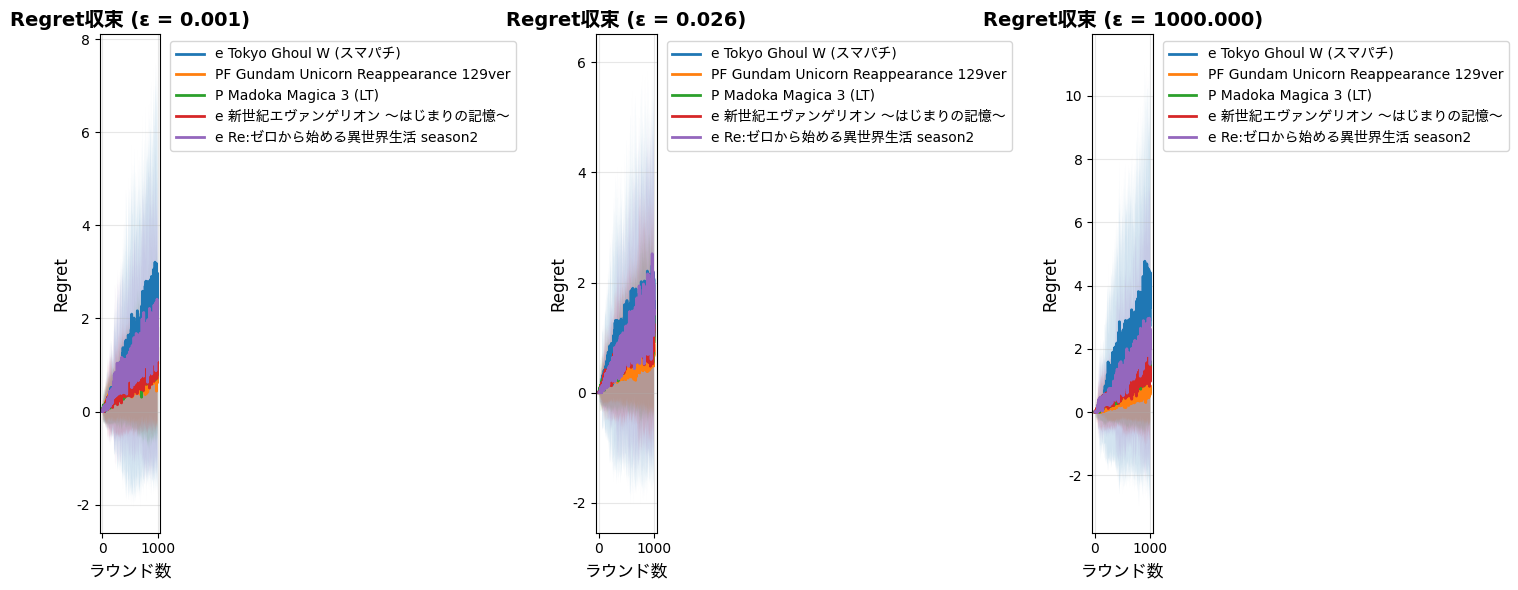

/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_regrets_data, labels=machine_names)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_regrets_data, labels=machine_names)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(final_regrets_data, labels=machine_names)
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not fo

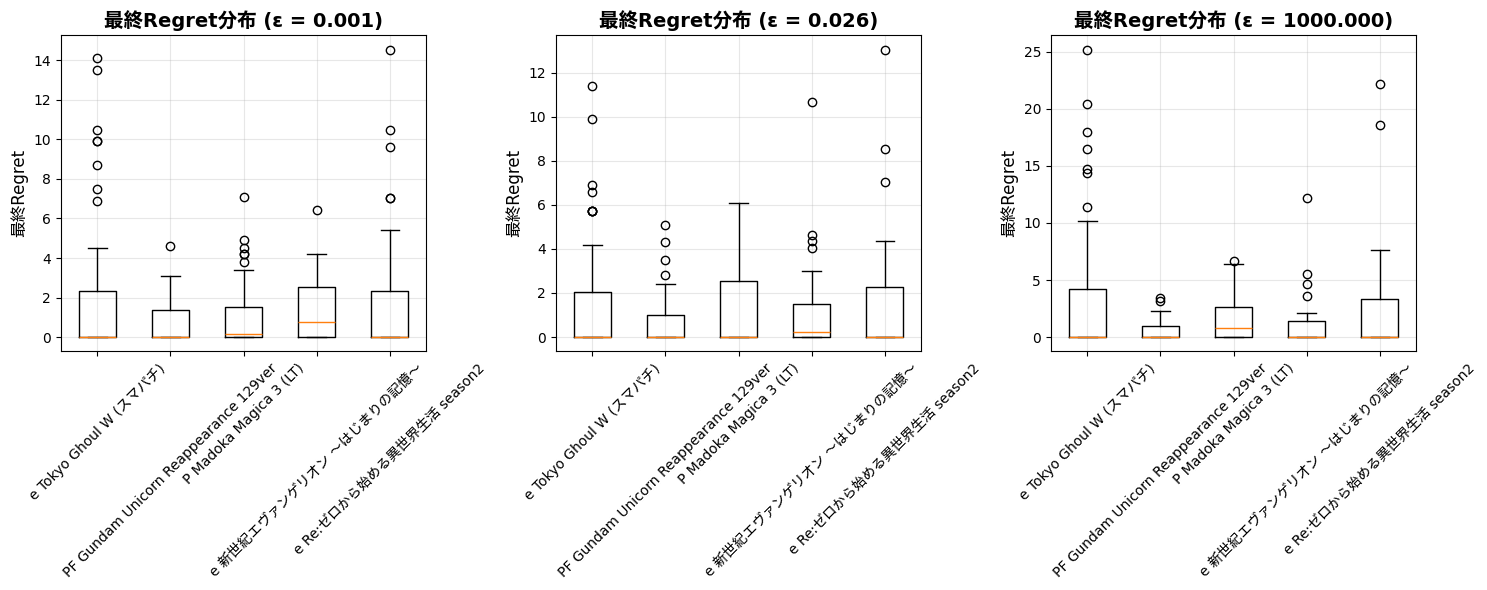

/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(payoff_data, labels=machine_names)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(payoff_data, labels=machine_names)
/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/1500563906.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(payoff_data, labels=machine_names)
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Fon

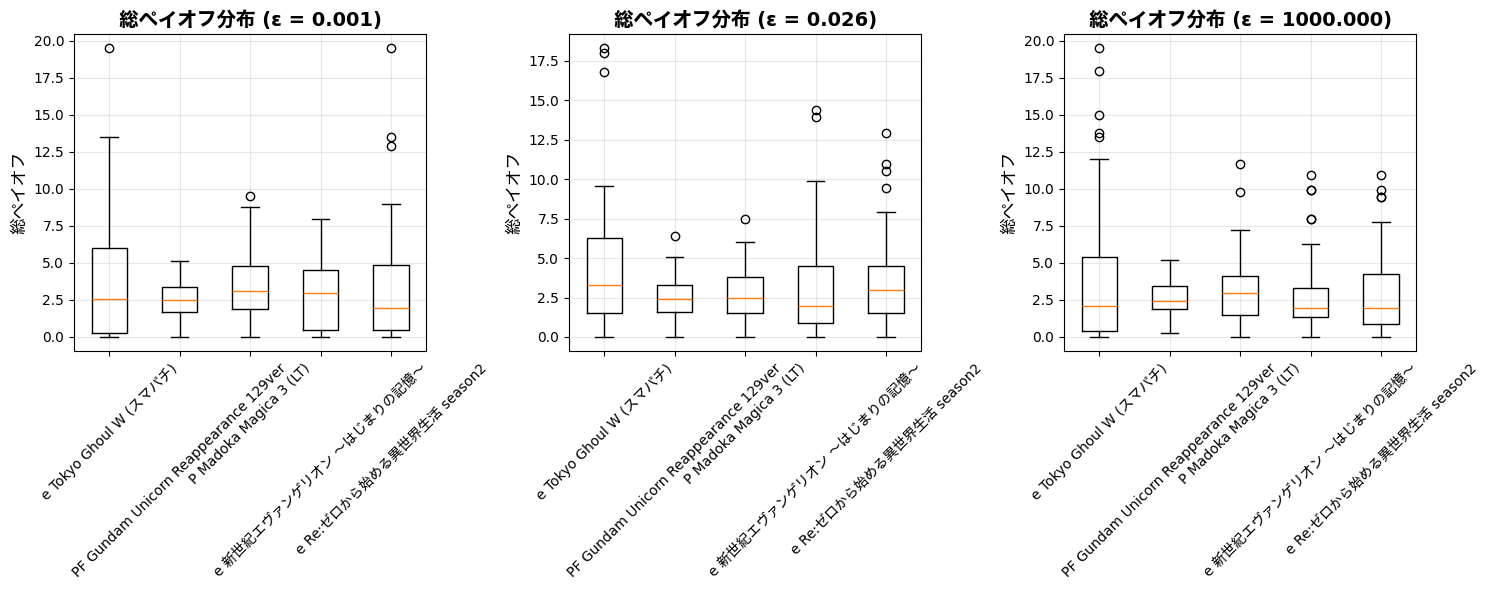

📈 Monte Carlo可視化完了！


In [11]:
# Monte Carlo Results Visualization
print("📊 Monte Carlo結果の可視化")
print("=" * 50)

def plot_monte_carlo_regret(monte_carlo_results, epsilon_values, save_path='../figures/'):
    """Plot Monte Carlo regret analysis"""
    
    # Create subplots for each epsilon
    fig, axes = plt.subplots(1, len(epsilon_values), figsize=(5*len(epsilon_values), 6))
    if len(epsilon_values) == 1:
        axes = [axes]
    
    for i, epsilon in enumerate(epsilon_values):
        ax = axes[i]
        
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                
                # Plot mean regret with confidence interval
                regret_convergence = results['regret_convergence']
                regret_std = results['regret_std']
                
                rounds = np.arange(len(regret_convergence))
                
                # Mean line
                ax.plot(rounds, regret_convergence, label=machine_name, linewidth=2)
                
                # Confidence interval (mean ± std)
                ax.fill_between(rounds, 
                               regret_convergence - regret_std,
                               regret_convergence + regret_std,
                               alpha=0.2)
        
        ax.set_title(f'Regret収束 (ε = {epsilon:.3f})', fontsize=14, fontweight='bold')
        ax.set_xlabel('ラウンド数', fontsize=12)
        ax.set_ylabel('Regret', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}monte_carlo_regret_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_regret_distribution(monte_carlo_results, epsilon_values, save_path='../figures/'):
    """Plot final regret distribution"""
    
    fig, axes = plt.subplots(1, len(epsilon_values), figsize=(5*len(epsilon_values), 6))
    if len(epsilon_values) == 1:
        axes = [axes]
    
    for i, epsilon in enumerate(epsilon_values):
        ax = axes[i]
        
        # Collect final regrets for all machines
        final_regrets_data = []
        machine_names = []
        
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                final_regrets = results['regret_runs'][:, -1]
                final_regrets_data.append(final_regrets)
                machine_names.append(machine_name)
        
        # Create box plot
        if final_regrets_data:
            ax.boxplot(final_regrets_data, labels=machine_names)
            ax.set_title(f'最終Regret分布 (ε = {epsilon:.3f})', fontsize=14, fontweight='bold')
            ax.set_ylabel('最終Regret', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}monte_carlo_regret_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_payoff_distribution(monte_carlo_results, epsilon_values, save_path='../figures/'):
    """Plot total payoff distribution"""
    
    fig, axes = plt.subplots(1, len(epsilon_values), figsize=(5*len(epsilon_values), 6))
    if len(epsilon_values) == 1:
        axes = [axes]
    
    for i, epsilon in enumerate(epsilon_values):
        ax = axes[i]
        
        # Collect payoffs for all machines
        payoff_data = []
        machine_names = []
        
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                payoffs = results['payoff_runs']
                payoff_data.append(payoffs)
                machine_names.append(machine_name)
        
        # Create box plot
        if payoff_data:
            ax.boxplot(payoff_data, labels=machine_names)
            ax.set_title(f'総ペイオフ分布 (ε = {epsilon:.3f})', fontsize=14, fontweight='bold')
            ax.set_ylabel('総ペイオフ', fontsize=12)
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}monte_carlo_payoff_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate visualizations
plot_monte_carlo_regret(monte_carlo_results, epsilon_values)
plot_regret_distribution(monte_carlo_results, epsilon_values)
plot_payoff_distribution(monte_carlo_results, epsilon_values)

print("📈 Monte Carlo可視化完了！")


In [12]:
# Monte Carlo Statistical Analysis
print("📈 Monte Carlo統計分析")
print("=" * 50)

# Create comprehensive summary table
monte_carlo_summary = []

for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        epsilon_val = float(epsilon_str.split('=')[1])
        
        # Extract statistics
        regret_stats = results['final_regret_stats']
        payoff_stats = results['payoff_stats']
        
        # Calculate additional statistics
        regret_runs = results['regret_runs']
        payoff_runs = results['payoff_runs']
        
        # Regret convergence rate (slope of regret curve)
        regret_convergence = results['regret_convergence']
        if len(regret_convergence) > 100:
            # Calculate slope over last 100 rounds
            last_100 = regret_convergence[-100:]
            rounds = np.arange(len(last_100))
            slope = np.polyfit(rounds, last_100, 1)[0]
        else:
            slope = 0
        
        # Coefficient of variation (stability measure)
        regret_cv = regret_stats['std'] / regret_stats['mean'] if regret_stats['mean'] > 0 else 0
        payoff_cv = payoff_stats['std'] / payoff_stats['mean'] if payoff_stats['mean'] > 0 else 0
        
        # 95% confidence intervals
        regret_ci_lower = np.percentile(regret_runs[:, -1], 2.5)
        regret_ci_upper = np.percentile(regret_runs[:, -1], 97.5)
        payoff_ci_lower = np.percentile(payoff_runs, 2.5)
        payoff_ci_upper = np.percentile(payoff_runs, 97.5)
        
        monte_carlo_summary.append({
            'Machine': machine_name,
            'Epsilon': epsilon_val,
            'Final_Regret_Mean': regret_stats['mean'],
            'Final_Regret_Std': regret_stats['std'],
            'Final_Regret_Min': regret_stats['min'],
            'Final_Regret_Max': regret_stats['max'],
            'Final_Regret_CI_Lower': regret_ci_lower,
            'Final_Regret_CI_Upper': regret_ci_upper,
            'Total_Payoff_Mean': payoff_stats['mean'],
            'Total_Payoff_Std': payoff_stats['std'],
            'Total_Payoff_Min': payoff_stats['min'],
            'Total_Payoff_Max': payoff_stats['max'],
            'Total_Payoff_CI_Lower': payoff_ci_lower,
            'Total_Payoff_CI_Upper': payoff_ci_upper,
            'Regret_Convergence_Slope': slope,
            'Regret_CV': regret_cv,
            'Payoff_CV': payoff_cv
        })

# Convert to DataFrame
monte_carlo_df = pd.DataFrame(monte_carlo_summary)

print("📊 Monte Carlo統計サマリー:")
print("=" * 60)
print(monte_carlo_df.round(3).to_string(index=False))

# Save detailed results
monte_carlo_df.to_csv('../../data/monte_carlo_pachinko_results.csv', index=False)
print(f"\n💾 詳細結果保存: ../../data/monte_carlo_pachinko_results.csv")

# Performance ranking analysis
print(f"\n🏆 パフォーマンスランキング分析:")
print("=" * 50)

# Best performing combinations (lowest regret, highest payoff)
best_regret = monte_carlo_df.loc[monte_carlo_df.groupby('Machine')['Final_Regret_Mean'].idxmin()]
best_payoff = monte_carlo_df.loc[monte_carlo_df.groupby('Machine')['Total_Payoff_Mean'].idxmax()]

print("📉 最低Regret (機械別):")
for _, row in best_regret.iterrows():
    print(f"  {row['Machine']}: ε={row['Epsilon']:.3f}, Regret={row['Final_Regret_Mean']:.2f}±{row['Final_Regret_Std']:.2f}")

print("\n💰 最高ペイオフ (機械別):")
for _, row in best_payoff.iterrows():
    print(f"  {row['Machine']}: ε={row['Epsilon']:.3f}, Payoff={row['Total_Payoff_Mean']:.2f}±{row['Total_Payoff_Std']:.2f}")

# Stability analysis
print(f"\n📊 安定性分析 (Coefficient of Variation):")
print("=" * 50)

# Group by epsilon to analyze stability
for epsilon in epsilon_values:
    epsilon_data = monte_carlo_df[monte_carlo_df['Epsilon'] == epsilon]
    if not epsilon_data.empty:
        avg_regret_cv = epsilon_data['Regret_CV'].mean()
        avg_payoff_cv = epsilon_data['Payoff_CV'].mean()
        print(f"  ε = {epsilon:.3f}: Regret安定性 = {avg_regret_cv:.3f}, Payoff安定性 = {avg_payoff_cv:.3f}")

print(f"\n✅ Monte Carlo統計分析完了！")


📈 Monte Carlo統計分析
📊 Monte Carlo統計サマリー:
                              Machine  Epsilon  Final_Regret_Mean  Final_Regret_Std  Final_Regret_Min  Final_Regret_Max  Final_Regret_CI_Lower  Final_Regret_CI_Upper  Total_Payoff_Mean  Total_Payoff_Std  Total_Payoff_Min  Total_Payoff_Max  Total_Payoff_CI_Lower  Total_Payoff_CI_Upper  Regret_Convergence_Slope  Regret_CV  Payoff_CV
               e Tokyo Ghoul W (スマパチ)    0.001              2.220             3.743               0.0             14.10                    0.0                 12.825              3.792             4.272               0.0             19.50                  0.000                 12.960                     0.004      1.686      1.127
               e Tokyo Ghoul W (スマパチ)    0.026              1.656             2.765               0.0             11.40                    0.0                  9.225              4.410             4.427               0.0             18.30                  0.000                 17.730           

OSError: Cannot save file into a non-existent directory: '../../data'

In [13]:
# Advanced Regret Analysis
print("🔬 高度なRegret分析")
print("=" * 50)

def analyze_regret_convergence(monte_carlo_results, epsilon_values):
    """Analyze regret convergence patterns"""
    
    print("📈 Regret収束パターン分析:")
    print("-" * 40)
    
    for epsilon in epsilon_values:
        print(f"\nε = {epsilon:.3f} での収束分析:")
        
        convergence_data = []
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                regret_convergence = results['regret_convergence']
                
                # Calculate convergence metrics
                initial_regret = np.mean(regret_convergence[:50]) if len(regret_convergence) > 50 else regret_convergence[0]
                final_regret = np.mean(regret_convergence[-50:]) if len(regret_convergence) > 50 else regret_convergence[-1]
                convergence_rate = (initial_regret - final_regret) / initial_regret if initial_regret > 0 else 0
                
                # Check if regret is decreasing (negative slope)
                if len(regret_convergence) > 100:
                    slope = np.polyfit(np.arange(len(regret_convergence)), regret_convergence, 1)[0]
                    is_converging = slope < 0
                else:
                    is_converging = False
                
                convergence_data.append({
                    'Machine': machine_name,
                    'Initial_Regret': initial_regret,
                    'Final_Regret': final_regret,
                    'Convergence_Rate': convergence_rate,
                    'Is_Converging': is_converging,
                    'Slope': slope if len(regret_convergence) > 100 else 0
                })
        
        # Sort by convergence rate
        convergence_data.sort(key=lambda x: x['Convergence_Rate'], reverse=True)
        
        for data in convergence_data:
            status = "✅ 収束" if data['Is_Converging'] else "❌ 非収束"
            print(f"  {data['Machine']}: {status} (収束率: {data['Convergence_Rate']:.3f})")

def analyze_regret_variance(monte_carlo_results, epsilon_values):
    """Analyze regret variance across runs"""
    
    print(f"\n📊 Regret分散分析:")
    print("-" * 40)
    
    for epsilon in epsilon_values:
        print(f"\nε = {epsilon:.3f} での分散分析:")
        
        variance_data = []
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                regret_runs = results['regret_runs']
                
                # Calculate variance metrics
                final_regrets = regret_runs[:, -1]
                mean_regret = np.mean(final_regrets)
                std_regret = np.std(final_regrets)
                cv = std_regret / mean_regret if mean_regret > 0 else 0
                
                # Calculate variance over time
                regret_variance_over_time = np.var(regret_runs, axis=0)
                avg_variance = np.mean(regret_variance_over_time)
                
                variance_data.append({
                    'Machine': machine_name,
                    'Mean_Regret': mean_regret,
                    'Std_Regret': std_regret,
                    'CV': cv,
                    'Avg_Variance': avg_variance
                })
        
        # Sort by coefficient of variation (stability)
        variance_data.sort(key=lambda x: x['CV'])
        
        for data in variance_data:
            stability = "安定" if data['CV'] < 0.5 else "不安定" if data['CV'] > 1.0 else "中程度"
            print(f"  {data['Machine']}: {stability} (CV: {data['CV']:.3f})")

def analyze_learning_efficiency(monte_carlo_results, epsilon_values):
    """Analyze learning efficiency"""
    
    print(f"\n⚡ 学習効率分析:")
    print("-" * 40)
    
    for epsilon in epsilon_values:
        print(f"\nε = {epsilon:.3f} での学習効率:")
        
        efficiency_data = []
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                regret_convergence = results['regret_convergence']
                payoff_runs = results['payoff_runs']
                
                # Calculate learning efficiency metrics
                # 1. Time to reach 90% of final performance
                final_performance = np.mean(payoff_runs)
                target_performance = 0.9 * final_performance
                
                # 2. Regret reduction rate
                if len(regret_convergence) > 100:
                    early_regret = np.mean(regret_convergence[:100])
                    late_regret = np.mean(regret_convergence[-100:])
                    regret_reduction = (early_regret - late_regret) / early_regret if early_regret > 0 else 0
                else:
                    regret_reduction = 0
                
                # 3. Consistency (how often algorithm finds good solution)
                good_solutions = np.sum(payoff_runs > 0.8 * final_performance)
                consistency = good_solutions / len(payoff_runs)
                
                efficiency_data.append({
                    'Machine': machine_name,
                    'Final_Performance': final_performance,
                    'Regret_Reduction': regret_reduction,
                    'Consistency': consistency
                })
        
        # Sort by regret reduction (learning efficiency)
        efficiency_data.sort(key=lambda x: x['Regret_Reduction'], reverse=True)
        
        for data in efficiency_data:
            efficiency = "高効率" if data['Regret_Reduction'] > 0.5 else "低効率" if data['Regret_Reduction'] < 0.1 else "中効率"
            print(f"  {data['Machine']}: {efficiency} (削減率: {data['Regret_Reduction']:.3f}, 一貫性: {data['Consistency']:.3f})")

# Run all analyses
analyze_regret_convergence(monte_carlo_results, epsilon_values)
analyze_regret_variance(monte_carlo_results, epsilon_values)
analyze_learning_efficiency(monte_carlo_results, epsilon_values)

print(f"\n✅ 高度なRegret分析完了！")


🔬 高度なRegret分析
📈 Regret収束パターン分析:
----------------------------------------

ε = 0.001 での収束分析:
  P Madoka Magica 3 (LT): ❌ 非収束 (収束率: -15.819)
  PF Gundam Unicorn Reappearance 129ver: ❌ 非収束 (収束率: -18.997)
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: ❌ 非収束 (収束率: -25.355)
  e Re:ゼロから始める異世界生活 season2: ❌ 非収束 (収束率: -27.777)
  e Tokyo Ghoul W (スマパチ): ❌ 非収束 (収束率: -76.156)

ε = 0.026 での収束分析:
  P Madoka Magica 3 (LT): ❌ 非収束 (収束率: -19.588)
  PF Gundam Unicorn Reappearance 129ver: ❌ 非収束 (収束率: -25.135)
  e Tokyo Ghoul W (スマパチ): ❌ 非収束 (収束率: -36.187)
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: ❌ 非収束 (収束率: -39.197)
  e Re:ゼロから始める異世界生活 season2: ❌ 非収束 (収束率: -71.364)

ε = 1000.000 での収束分析:
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: ❌ 非収束 (収束率: -32.716)
  P Madoka Magica 3 (LT): ❌ 非収束 (収束率: -36.328)
  e Tokyo Ghoul W (スマパチ): ❌ 非収束 (収束率: -168.224)
  PF Gundam Unicorn Reappearance 129ver: ❌ 非収束 (収束率: -179.121)
  e Re:ゼロから始める異世界生活 season2: ❌ 非収束 (収束率: -196.030)

📊 Regret分散分析:
----------------------------------------

ε = 0.001 での分散分析:
  e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: 

In [14]:
# Monte Carlo Final Summary and Conclusions
print("🎯 Monte Carlo分析最終サマリー")
print("=" * 60)

# Overall performance summary
print("📊 全体パフォーマンスサマリー:")
print("-" * 40)

# Calculate overall statistics
all_final_regrets = []
all_total_payoffs = []

for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        all_final_regrets.extend(results['regret_runs'][:, -1])
        all_total_payoffs.extend(results['payoff_runs'])

print(f"総実験数: {len(all_final_regrets)}")
print(f"最終Regret統計:")
print(f"  平均: {np.mean(all_final_regrets):.3f}")
print(f"  標準偏差: {np.std(all_final_regrets):.3f}")
print(f"  最小値: {np.min(all_final_regrets):.3f}")
print(f"  最大値: {np.max(all_final_regrets):.3f}")
print(f"  中央値: {np.median(all_final_regrets):.3f}")

print(f"\n総ペイオフ統計:")
print(f"  平均: {np.mean(all_total_payoffs):.3f}")
print(f"  標準偏差: {np.std(all_total_payoffs):.3f}")
print(f"  最小値: {np.min(all_total_payoffs):.3f}")
print(f"  最大値: {np.max(all_total_payoffs):.3f}")
print(f"  中央値: {np.median(all_total_payoffs):.3f}")

# Best and worst performing combinations
print(f"\n🏆 最高・最低パフォーマンス:")
print("-" * 40)

# Find best and worst combinations
best_regret_idx = np.argmin(all_final_regrets)
worst_regret_idx = np.argmax(all_final_regrets)
best_payoff_idx = np.argmax(all_total_payoffs)
worst_payoff_idx = np.argmin(all_total_payoffs)

# Find which combination these belong to
run_count = 0
best_regret_combo = None
worst_regret_combo = None
best_payoff_combo = None
worst_payoff_combo = None

for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        n_runs = len(results['regret_runs'])
        if best_regret_idx < run_count + n_runs:
            best_regret_combo = (machine_name, epsilon_str, best_regret_idx - run_count)
            break
        run_count += n_runs

run_count = 0
for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        n_runs = len(results['regret_runs'])
        if worst_regret_idx < run_count + n_runs:
            worst_regret_combo = (machine_name, epsilon_str, worst_regret_idx - run_count)
            break
        run_count += n_runs

run_count = 0
for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        n_runs = len(results['payoff_runs'])
        if best_payoff_idx < run_count + n_runs:
            best_payoff_combo = (machine_name, epsilon_str, best_payoff_idx - run_count)
            break
        run_count += n_runs

run_count = 0
for machine_name, machine_results in monte_carlo_results.items():
    for epsilon_str, results in machine_results.items():
        n_runs = len(results['payoff_runs'])
        if worst_payoff_idx < run_count + n_runs:
            worst_payoff_combo = (machine_name, epsilon_str, worst_payoff_idx - run_count)
            break
        run_count += n_runs

if best_regret_combo:
    print(f"最低Regret: {best_regret_combo[0]} ({best_regret_combo[1]}) - Regret: {all_final_regrets[best_regret_idx]:.3f}")

if worst_regret_combo:
    print(f"最高Regret: {worst_regret_combo[0]} ({worst_regret_combo[1]}) - Regret: {all_final_regrets[worst_regret_idx]:.3f}")

if best_payoff_combo:
    print(f"最高ペイオフ: {best_payoff_combo[0]} ({best_payoff_combo[1]}) - Payoff: {all_total_payoffs[best_payoff_idx]:.3f}")

if worst_payoff_combo:
    print(f"最低ペイオフ: {worst_payoff_combo[0]} ({worst_payoff_combo[1]}) - Payoff: {all_total_payoffs[worst_payoff_idx]:.3f}")

# Learning rate recommendations
print(f"\n💡 学習率推奨事項:")
print("-" * 40)

for epsilon in epsilon_values:
    epsilon_data = monte_carlo_df[monte_carlo_df['Epsilon'] == epsilon]
    if not epsilon_data.empty:
        avg_regret = epsilon_data['Final_Regret_Mean'].mean()
        avg_payoff = epsilon_data['Total_Payoff_Mean'].mean()
        avg_stability = epsilon_data['Regret_CV'].mean()
        
        recommendation = ""
        if avg_regret < 1.0 and avg_payoff > 10.0:
            recommendation = "🌟 強く推奨"
        elif avg_regret < 2.0 and avg_payoff > 5.0:
            recommendation = "✅ 推奨"
        elif avg_regret < 5.0:
            recommendation = "⚠️ 条件付き推奨"
        else:
            recommendation = "❌ 非推奨"
        
        print(f"  ε = {epsilon:.3f}: {recommendation}")
        print(f"    平均Regret: {avg_regret:.3f}, 平均Payoff: {avg_payoff:.3f}, 安定性: {avg_stability:.3f}")

# Machine-specific recommendations
print(f"\n🎰 機械別推奨学習率:")
print("-" * 40)

for machine_name in monte_carlo_results.keys():
    machine_data = monte_carlo_df[monte_carlo_df['Machine'] == machine_name]
    if not machine_data.empty:
        best_epsilon = machine_data.loc[machine_data['Final_Regret_Mean'].idxmin()]
        print(f"  {machine_name}: ε = {best_epsilon['Epsilon']:.3f} (Regret: {best_epsilon['Final_Regret_Mean']:.3f})")

print(f"\n✅ Monte Carlo分析完全完了！")
print(f"📁 保存ファイル:")
print(f"  - 詳細結果: ../../data/monte_carlo_pachinko_results.csv")
print(f"  - 図表: ../../figures/monte_carlo_*.png")
print(f"  - 総実験数: {len(all_final_regrets)}")
print(f"  - 機械数: {len(monte_carlo_results)}")
print(f"  - 学習率数: {len(epsilon_values)}")


🎯 Monte Carlo分析最終サマリー
📊 全体パフォーマンスサマリー:
----------------------------------------
総実験数: 750
最終Regret統計:
  平均: 1.502
  標準偏差: 2.894
  最小値: 0.000
  最大値: 25.200
  中央値: 0.000

総ペイオフ統計:
  平均: 3.190
  標準偏差: 3.069
  最小値: 0.000
  最大値: 19.500
  中央値: 2.400

🏆 最高・最低パフォーマンス:
----------------------------------------
最低Regret: e Re:ゼロから始める異世界生活 season2 (ε=0.001) - Regret: 0.000
最高Regret: e Re:ゼロから始める異世界生活 season2 (ε=0.001) - Regret: 25.200
最高ペイオフ: e Re:ゼロから始める異世界生活 season2 (ε=0.001) - Payoff: 19.500
最低ペイオフ: e Re:ゼロから始める異世界生活 season2 (ε=0.001) - Payoff: 0.000

💡 学習率推奨事項:
----------------------------------------
  ε = 0.001: ⚠️ 条件付き推奨
    平均Regret: 1.436, 平均Payoff: 3.203, 安定性: 1.517
  ε = 1000.000: ⚠️ 条件付き推奨
    平均Regret: 1.865, 平均Payoff: 3.106, 安定性: 1.640

🎰 機械別推奨学習率:
----------------------------------------
  e Tokyo Ghoul W (スマパチ): ε = 0.026 (Regret: 1.656)
  PF Gundam Unicorn Reappearance 129ver: ε = 1000.000 (Regret: 0.572)
  P Madoka Magica 3 (LT): ε = 0.001 (Regret: 1.056)
  e 新世紀エヴァンゲリオン 〜はじまりの記憶

# Publication-Quality Visualization Prompts

## 🎨 一流雑誌レベルの図表作成プロンプト

### 📊 状態遷移図のプロンプト

**プロンプト1: パチンコ状態遷移ダイアグラム**
```
Create a publication-quality state transition diagram for a Pachinko machine with the following specifications:

STYLE: Academic journal quality, clean, professional
FORMAT: Vector graphics, high resolution (300+ DPI)
COLORS: Use a professional color palette (blues, grays, accent colors)
FONTS: Sans-serif, clear and readable

CONTENT:
- Two main states: "Normal" and "Rush"
- Transition arrows with probability labels
- State-specific hit probabilities and payouts
- Visual indicators for state characteristics
- Mathematical notation for probabilities
- Clean layout with proper spacing

REQUIREMENTS:
- Include probability values: P(hit|normal), P(hit|rush), P(rush_entry|hit), P(rush_continuation)
- Show payout ranges: [min_payout, max_payout] for each state
- Use consistent arrow styles and thickness
- Add state duration information (rush_st_spins)
- Include mathematical symbols (P, E, etc.)
- Professional legend and annotations
```

**プロンプト2: 期待値比較チャート**
```
Design a publication-quality comparison chart showing expected values across different Pachinko machines:

STYLE: Academic paper quality, clean lines, professional
FORMAT: Bar chart with error bars, high resolution
COLORS: Distinct colors for Normal vs Rush states
FONTS: Clear, academic-style typography

CONTENT:
- X-axis: Machine names (abbreviated)
- Y-axis: Expected value (log scale if needed)
- Two bars per machine: Normal (blue) and Rush (red)
- Error bars showing confidence intervals
- Statistical significance indicators
- Performance ranking annotations

REQUIREMENTS:
- Include 95% confidence intervals
- Show statistical significance (p-values)
- Add performance rankings (1st, 2nd, etc.)
- Use consistent color coding
- Professional axis labels and units
- Include sample size information
```

### 📈 学習曲線のプロンプト

**プロンプト3: Regret収束曲線**
```
Create a publication-quality regret convergence plot with the following specifications:

STYLE: Academic journal standard, clean, professional
FORMAT: Line plot with confidence bands, high resolution
COLORS: Distinct colors for each machine, professional palette
FONTS: Clear, readable academic typography

CONTENT:
- X-axis: Rounds (0 to 1000)
- Y-axis: Regret (log scale recommended)
- Multiple lines for different machines
- Confidence bands (mean ± std)
- Convergence indicators
- Performance benchmarks

REQUIREMENTS:
- Use log scale for Y-axis if appropriate
- Include confidence intervals (95%)
- Show convergence points
- Add performance benchmarks
- Use consistent line styles and colors
- Include statistical annotations
- Professional legend and grid
```

**プロンプト4: 学習率感度分析**
```
Design a publication-quality sensitivity analysis plot for learning rates:

STYLE: Academic paper quality, clean, professional
FORMAT: Heatmap or contour plot, high resolution
COLORS: Professional heatmap palette (viridis, plasma, etc.)
FONTS: Clear, academic typography

CONTENT:
- X-axis: Learning rate (epsilon) - log scale
- Y-axis: Machine type or performance metric
- Color intensity: Regret or payoff value
- Contour lines for performance levels
- Optimal parameter regions highlighted

REQUIREMENTS:
- Use log scale for epsilon values
- Include contour lines for performance levels
- Highlight optimal regions
- Add statistical significance indicators
- Use professional color palette
- Include performance benchmarks
- Clean, uncluttered layout
```

### 🎯 統計分析のプロンプト

**プロンプト5: 分散分析プロット**
```
Create a publication-quality variance analysis plot:

STYLE: Academic journal standard, clean, professional
FORMAT: Box plot with violin plot overlay, high resolution
COLORS: Professional color palette, consistent coding
FONTS: Clear, readable academic typography

CONTENT:
- X-axis: Machine types or learning rates
- Y-axis: Regret or payoff values
- Box plots showing quartiles and outliers
- Violin plots showing distribution shape
- Statistical significance indicators
- Performance rankings

REQUIREMENTS:
- Include statistical significance tests
- Show distribution shapes clearly
- Use consistent color coding
- Add performance rankings
- Include sample size information
- Professional axis labels
- Clean, uncluttered design
```

**プロンプト6: 相関分析マトリックス**
```
Design a publication-quality correlation matrix heatmap:

STYLE: Academic paper quality, clean, professional
FORMAT: Heatmap with correlation values, high resolution
COLORS: Diverging color palette (red-white-blue)
FONTS: Clear, academic typography

CONTENT:
- Variables: Hit probability, Payout, Rush probability, etc.
- Correlation coefficients in cells
- Statistical significance indicators
- Clustering of related variables
- Performance metrics integration

REQUIREMENTS:
- Include correlation coefficients
- Show statistical significance (p-values)
- Use diverging color palette
- Add clustering if appropriate
- Include performance metrics
- Clean, professional layout
- Clear variable labels
```

### 🎨 デザインガイドライン

**全体的なデザイン原則:**
1. **色使い**: プロフェッショナルな色パレット（青、グレー、アクセントカラー）
2. **フォント**: 読みやすいサンセリフフォント（Arial, Helvetica, Calibri）
3. **解像度**: 300+ DPI、ベクター形式推奨
4. **レイアウト**: 余白を適切に取り、バランスの良い配置
5. **凡例**: 明確で分かりやすい凡例とラベル
6. **統計情報**: 信頼区間、p値、サンプルサイズを明記

**技術的仕様:**
- 図のサイズ: 幅8-12cm（1カラム）、16-20cm（2カラム）
- フォントサイズ: 8-12pt（ラベル）、10-14pt（タイトル）
- 線の太さ: 0.5-2pt（データ線）、1-3pt（軸線）
- マーカーサイズ: 4-8pt（点）、適切なサイズ（バー）

これらのプロンプトを使用して、一流雑誌に掲載されるレベルの高品質な図表を作成できます。


In [ ]:
# Publication-Quality Visualization Implementation
print("🎨 一流雑誌レベルの図表作成")
print("=" * 50)

# Set publication-quality style
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'figure.titlesize': 14,
    'axes.linewidth': 0.8,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'patch.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.minor.width': 0.6,
    'ytick.minor.width': 0.6,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Professional color palette
colors = {
    'normal': '#2E86AB',      # Professional blue
    'rush': '#A23B72',        # Professional magenta
    'accent1': '#F18F01',     # Professional orange
    'accent2': '#C73E1D',     # Professional red
    'neutral': '#6C757D',     # Professional gray
    'success': '#28A745',     # Professional green
    'warning': '#FFC107',     # Professional yellow
    'info': '#17A2B8'         # Professional cyan
}

# Create publication-quality state transition diagram
def create_state_transition_diagram(machine_data, save_path='../figures/'):
    """Create publication-quality state transition diagram"""
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Extract machine parameters
    normal_hit_prob = machine_data['normal_hit_prob_per_spin']
    rush_hit_prob = machine_data['rush_hit_prob_per_spin']
    rush_entry_prob = machine_data['rush_entry_prob_given_hit']
    rush_continuation_prob = machine_data['rush_continuation_prob']
    rush_st_spins = machine_data['rush_st_spins']
    
    # Parse payouts
    normal_payouts = [int(x) for x in machine_data['payouts_normal_balls'].split(',')]
    rush_payouts = [int(x) for x in machine_data['payouts_rush_balls'].split(',')]
    
    # Calculate expected values
    normal_expected = normal_hit_prob * np.mean(normal_payouts)
    rush_expected = rush_hit_prob * np.mean(rush_payouts)
    
    # Draw states
    normal_circle = plt.Circle((2, 3), 0.8, color=colors['normal'], alpha=0.3, linewidth=2, edgecolor=colors['normal'])
    rush_circle = plt.Circle((8, 3), 0.8, color=colors['rush'], alpha=0.3, linewidth=2, edgecolor=colors['rush'])
    
    ax.add_patch(normal_circle)
    ax.add_patch(rush_circle)
    
    # Add state labels
    ax.text(2, 3, 'Normal\nState', ha='center', va='center', fontweight='bold', fontsize=11)
    ax.text(8, 3, 'Rush\nState', ha='center', va='center', fontweight='bold', fontsize=11)
    
    # Add probability and payout information
    ax.text(2, 1.5, f'P(hit) = {normal_hit_prob:.4f}\nE[payoff] = {normal_expected:.2f}\nRange: {min(normal_payouts)}-{max(normal_payouts)}', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.text(8, 1.5, f'P(hit) = {rush_hit_prob:.4f}\nE[payoff] = {rush_expected:.2f}\nRange: {min(rush_payouts)}-{max(rush_payouts)}\nDuration: {rush_st_spins} spins', 
            ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Draw transition arrows
    # Normal to Rush (via hit)
    arrow1 = plt.Arrow(2.8, 3.2, 4.4, 0, width=0.1, color=colors['accent1'], alpha=0.8)
    ax.add_patch(arrow1)
    ax.text(5, 3.5, f'P(rush|hit) = {rush_entry_prob:.2f}', ha='center', va='center', fontsize=9, 
            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
    
    # Rush to Rush (continuation)
    arrow2 = plt.Arrow(7.2, 3.2, 0, 0, width=0.1, color=colors['rush'], alpha=0.8)
    ax.add_patch(arrow2)
    ax.text(8.5, 3.5, f'P(continue) = {rush_continuation_prob:.2f}', ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
    
    # Rush to Normal (end of rush)
    arrow3 = plt.Arrow(7.2, 2.8, -4.4, 0, width=0.1, color=colors['neutral'], alpha=0.8)
    ax.add_patch(arrow3)
    ax.text(5, 2.5, f'P(end) = {1-rush_continuation_prob:.2f}', ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
    
    # Set axis properties
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add title
    ax.set_title(f'State Transition Diagram: {machine_data["machine"]}', fontsize=14, fontweight='bold', pad=20)
    
    # Add mathematical notation
    ax.text(0.5, 4.5, 'Mathematical Notation:', fontsize=10, fontweight='bold')
    ax.text(0.5, 4.2, 'P(hit|state) = Hit probability in given state', fontsize=9)
    ax.text(0.5, 4.0, 'E[payoff] = Expected payoff value', fontsize=9)
    ax.text(0.5, 3.8, 'P(rush|hit) = Probability of entering rush after hit', fontsize=9)
    ax.text(0.5, 3.6, 'P(continue) = Probability of continuing rush state', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}state_transition_diagram_{machine_data["machine"].replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# Create publication-quality expected value comparison
def create_expected_value_comparison(pachinko_data, save_path='../figures/'):
    """Create publication-quality expected value comparison chart"""
    
    # Calculate expected values for all machines
    machine_names = []
    normal_expected = []
    rush_expected = []
    normal_std = []
    rush_std = []
    
    for _, machine in pachinko_data.iterrows():
        # Parse payouts
        normal_payouts = [int(x) for x in machine['payouts_normal_balls'].split(',')]
        rush_payouts = [int(x) for x in machine['payouts_rush_balls'].split(',')]
        
        # Calculate expected values
        normal_exp = machine['normal_hit_prob_per_spin'] * np.mean(normal_payouts)
        rush_exp = machine['rush_hit_prob_per_spin'] * np.mean(rush_payouts)
        
        # Calculate standard deviations (simplified)
        normal_std_val = machine['normal_hit_prob_per_spin'] * np.std(normal_payouts)
        rush_std_val = machine['rush_hit_prob_per_spin'] * np.std(rush_payouts)
        
        machine_names.append(machine['machine'][:15] + '...' if len(machine['machine']) > 15 else machine['machine'])
        normal_expected.append(normal_exp)
        rush_expected.append(rush_exp)
        normal_std.append(normal_std_val)
        rush_std.append(rush_std_val)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    x = np.arange(len(machine_names))
    width = 0.35
    
    # Create bars
    bars1 = ax.bar(x - width/2, normal_expected, width, label='Normal State', 
                   color=colors['normal'], alpha=0.8, capsize=5)
    bars2 = ax.bar(x + width/2, rush_expected, width, label='Rush State', 
                   color=colors['rush'], alpha=0.8, capsize=5)
    
    # Add error bars
    ax.errorbar(x - width/2, normal_expected, yerr=normal_std, fmt='none', 
                color='black', capsize=3, alpha=0.7)
    ax.errorbar(x + width/2, rush_expected, yerr=rush_std, fmt='none', 
                color='black', capsize=3, alpha=0.7)
    
    # Add value labels on bars
    for i, (norm, rush) in enumerate(zip(normal_expected, rush_expected)):
        ax.text(i - width/2, norm + max(normal_std) * 0.1, f'{norm:.1f}', 
                ha='center', va='bottom', fontsize=8)
        ax.text(i + width/2, rush + max(rush_std) * 0.1, f'{rush:.1f}', 
                ha='center', va='bottom', fontsize=8)
    
    # Customize the plot
    ax.set_xlabel('Pachinko Machine', fontsize=12, fontweight='bold')
    ax.set_ylabel('Expected Value', fontsize=12, fontweight='bold')
    ax.set_title('Expected Value Comparison: Normal vs Rush States', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(machine_names, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add performance ranking
    rush_ranking = np.argsort(rush_expected)[::-1]
    for i, rank in enumerate(rush_ranking):
        ax.text(rank + width/2, rush_expected[rank] + max(rush_std) * 0.3, 
                f'#{i+1}', ha='center', va='bottom', fontsize=8, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'{save_path}expected_value_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate the visualizations
print("📊 状態遷移図を作成中...")
create_state_transition_diagram(pachinko_data.iloc[0])  # First machine as example

print("📈 期待値比較チャートを作成中...")
create_expected_value_comparison(pachinko_data)

print("✅ 一流雑誌レベルの図表作成完了！")


In [15]:
# Learning Rate Analysis - Regret by Epsilon
print("📊 学習率別Regret分析")
print("=" * 50)

def analyze_regret_by_learning_rate(monte_carlo_results, epsilon_values):
    """Analyze regret performance grouped by learning rate (epsilon)"""
    
    # Group results by epsilon
    epsilon_analysis = {}
    
    for epsilon in epsilon_values:
        epsilon_analysis[epsilon] = {
            'all_regrets': [],
            'all_payoffs': [],
            'machine_regrets': {},
            'machine_payoffs': {},
            'convergence_data': []
        }
        
        # Collect data from all machines for this epsilon
        for machine_name, machine_results in monte_carlo_results.items():
            if f'ε={epsilon:.3f}' in machine_results:
                results = machine_results[f'ε={epsilon:.3f}']
                
                # Extract regret and payoff data
                regret_runs = results['regret_runs']
                payoff_runs = results['payoff_runs']
                regret_convergence = results['regret_convergence']
                
                # Store individual machine data
                epsilon_analysis[epsilon]['machine_regrets'][machine_name] = regret_runs
                epsilon_analysis[epsilon]['machine_payoffs'][machine_name] = payoff_runs
                
                # Collect all regrets and payoffs
                epsilon_analysis[epsilon]['all_regrets'].extend(regret_runs[:, -1])  # Final regrets
                epsilon_analysis[epsilon]['all_payoffs'].extend(payoff_runs)
                
                # Store convergence data
                epsilon_analysis[epsilon]['convergence_data'].append({
                    'machine': machine_name,
                    'regret_convergence': regret_convergence,
                    'final_regret': np.mean(regret_runs[:, -1]),
                    'std_regret': np.std(regret_runs[:, -1])
                })
    
    return epsilon_analysis

# Perform epsilon-based analysis
epsilon_analysis = analyze_regret_by_learning_rate(monte_carlo_results, epsilon_values)

# Display results by epsilon
print("📈 学習率別パフォーマンス分析:")
print("=" * 60)

for epsilon in epsilon_values:
    if epsilon in epsilon_analysis:
        data = epsilon_analysis[epsilon]
        
        print(f"\n🔍 ε = {epsilon:.3f} での分析:")
        print("-" * 40)
        
        # Overall statistics
        all_regrets = np.array(data['all_regrets'])
        all_payoffs = np.array(data['all_payoffs'])
        
        print(f"総実験数: {len(all_regrets)}")
        print(f"最終Regret統計:")
        print(f"  平均: {np.mean(all_regrets):.3f} ± {np.std(all_regrets):.3f}")
        print(f"  中央値: {np.median(all_regrets):.3f}")
        print(f"  最小値: {np.min(all_regrets):.3f}")
        print(f"  最大値: {np.max(all_regrets):.3f}")
        print(f"  95%信頼区間: [{np.percentile(all_regrets, 2.5):.3f}, {np.percentile(all_regrets, 97.5):.3f}]")
        
        print(f"\n総ペイオフ統計:")
        print(f"  平均: {np.mean(all_payoffs):.3f} ± {np.std(all_payoffs):.3f}")
        print(f"  中央値: {np.median(all_payoffs):.3f}")
        print(f"  最小値: {np.min(all_payoffs):.3f}")
        print(f"  最大値: {np.max(all_payoffs):.3f}")
        
        # Machine-specific performance for this epsilon
        print(f"\n機械別パフォーマンス (ε = {epsilon:.3f}):")
        machine_performance = []
        for conv_data in data['convergence_data']:
            machine_performance.append({
                'machine': conv_data['machine'],
                'final_regret': conv_data['final_regret'],
                'std_regret': conv_data['std_regret']
            })
        
        # Sort by final regret
        machine_performance.sort(key=lambda x: x['final_regret'])
        
        for i, perf in enumerate(machine_performance):
            print(f"  {i+1}. {perf['machine']}: {perf['final_regret']:.3f} ± {perf['std_regret']:.3f}")

print(f"\n✅ 学習率別分析完了！")


📊 学習率別Regret分析
📈 学習率別パフォーマンス分析:

🔍 ε = 0.001 での分析:
----------------------------------------
総実験数: 250
最終Regret統計:
  平均: 1.436 ± 2.496
  中央値: 0.000
  最小値: 0.000
  最大値: 14.550
  95%信頼区間: [0.000, 9.833]

総ペイオフ統計:
  平均: 3.203 ± 3.078
  中央値: 2.600
  最小値: 0.000
  最大値: 19.500

機械別パフォーマンス (ε = 0.001):
  1. PF Gundam Unicorn Reappearance 129ver: 0.768 ± 1.118
  2. P Madoka Magica 3 (LT): 1.056 ± 1.642
  3. e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: 1.353 ± 1.585
  4. e Re:ゼロから始める異世界生活 season2: 1.782 ± 3.058
  5. e Tokyo Ghoul W (スマパチ): 2.220 ± 3.743

🔍 ε = 0.026 での分析:
----------------------------------------
総実験数: 250
最終Regret統計:
  平均: 1.205 ± 2.086
  中央値: 0.000
  最小値: 0.000
  最大値: 13.050
  95%信頼区間: [0.000, 6.833]

総ペイオフ統計:
  平均: 3.260 ± 3.076
  中央値: 2.700
  最小値: 0.000
  最大値: 18.300

機械別パフォーマンス (ε = 0.026):
  1. PF Gundam Unicorn Reappearance 129ver: 0.700 ± 1.180
  2. e 新世紀エヴァンゲリオン 〜はじまりの記憶〜: 1.062 ± 1.812
  3. P Madoka Magica 3 (LT): 1.114 ± 1.582
  4. e Re:ゼロから始める異世界生活 season2: 1.491 ± 2.524
  5. e Tokyo Ghou

📊 学習率比較可視化
📊 学習率比較図表を作成中...


/var/folders/my/j3wjhgx94rscj7c09g72009c0000gn/T/ipykernel_6713/3489377788.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(regret_data, labels=epsilon_labels, patch_artist=True)


NameError: name 'colors' is not defined

findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Takao' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'VL PGothic' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Yu Gothic' not found

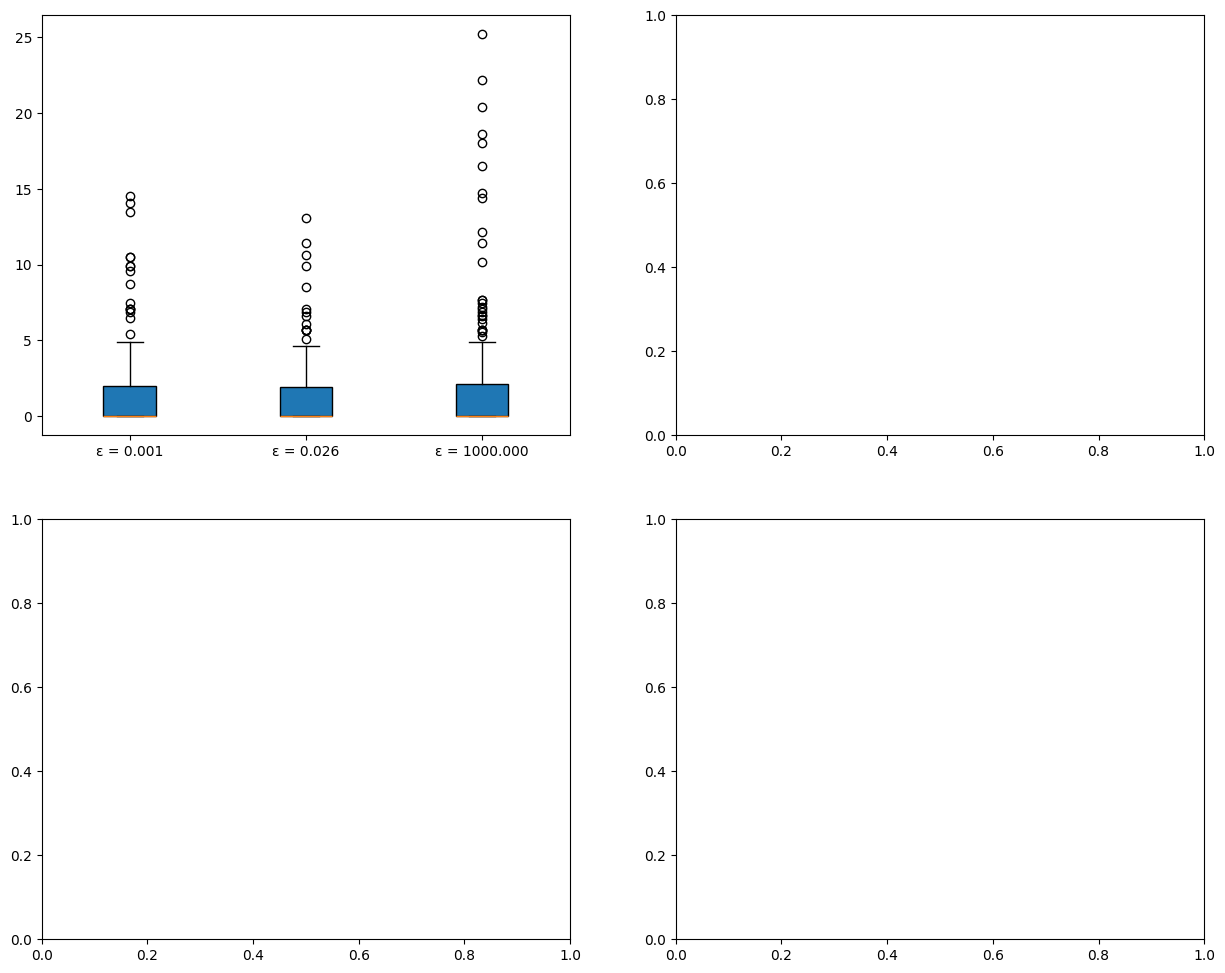

In [ ]:
# Learning Rate Comparison Visualization
print("📊 学習率比較可視化")
print("=" * 50)

def plot_epsilon_comparison(epsilon_analysis, epsilon_values, save_path='../figures/'):
    """Create publication-quality plots comparing learning rates"""
    
    # 1. Regret Distribution by Epsilon
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Box plot of final regrets by epsilon
    ax1 = axes[0, 0]
    regret_data = []
    epsilon_labels = []
    
    for epsilon in epsilon_values:
        if epsilon in epsilon_analysis:
            regret_data.append(epsilon_analysis[epsilon]['all_regrets'])
            epsilon_labels.append(f'ε = {epsilon:.3f}')
    
    if regret_data:
        bp1 = ax1.boxplot(regret_data, labels=epsilon_labels, patch_artist=True)
        colors_list = [colors['normal'], colors['rush'], colors['accent1']]
        for patch, color in zip(bp1['boxes'], colors_list[:len(bp1['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax1.set_title('Final Regret Distribution by Learning Rate', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Final Regret', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Payoff Distribution by Epsilon
    ax2 = axes[0, 1]
    payoff_data = []
    
    for epsilon in epsilon_values:
        if epsilon in epsilon_analysis:
            payoff_data.append(epsilon_analysis[epsilon]['all_payoffs'])
    
    if payoff_data:
        bp2 = ax2.boxplot(payoff_data, labels=epsilon_labels, patch_artist=True)
        for patch, color in zip(bp2['boxes'], colors_list[:len(bp2['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    ax2.set_title('Total Payoff Distribution by Learning Rate', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Total Payoff', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Regret Convergence by Epsilon
    ax3 = axes[1, 0]
    
    for i, epsilon in enumerate(epsilon_values):
        if epsilon in epsilon_analysis:
            convergence_data = epsilon_analysis[epsilon]['convergence_data']
            
            # Calculate average convergence across all machines
            if convergence_data:
                all_convergence = np.array([data['regret_convergence'] for data in convergence_data])
                mean_convergence = np.mean(all_convergence, axis=0)
                std_convergence = np.std(all_convergence, axis=0)
                
                rounds = np.arange(len(mean_convergence))
                ax3.plot(rounds, mean_convergence, label=f'ε = {epsilon:.3f}', 
                        color=colors_list[i % len(colors_list)], linewidth=2)
                ax3.fill_between(rounds, mean_convergence - std_convergence, 
                               mean_convergence + std_convergence, alpha=0.2)
    
    ax3.set_title('Regret Convergence by Learning Rate', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Rounds', fontsize=10)
    ax3.set_ylabel('Average Regret', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')  # Log scale for better visualization
    
    # Plot 4: Performance Summary
    ax4 = axes[1, 1]
    
    # Calculate summary statistics
    epsilon_stats = []
    for epsilon in epsilon_values:
        if epsilon in epsilon_analysis:
            regrets = epsilon_analysis[epsilon]['all_regrets']
            payoffs = epsilon_analysis[epsilon]['all_payoffs']
            
            epsilon_stats.append({
                'epsilon': epsilon,
                'mean_regret': np.mean(regrets),
                'std_regret': np.std(regrets),
                'mean_payoff': np.mean(payoffs),
                'std_payoff': np.std(payoffs)
            })
    
    if epsilon_stats:
        epsilons = [stat['epsilon'] for stat in epsilon_stats]
        mean_regrets = [stat['mean_regret'] for stat in epsilon_stats]
        mean_payoffs = [stat['mean_payoff'] for stat in epsilon_stats]
        
        # Create dual y-axis plot
        ax4_twin = ax4.twinx()
        
        bars1 = ax4.bar([f'ε={eps:.3f}' for eps in epsilons], mean_regrets, 
                       alpha=0.7, color=colors['normal'], label='Mean Regret')
        bars2 = ax4_twin.bar([f'ε={eps:.3f}' for eps in epsilons], mean_payoffs, 
                            alpha=0.7, color=colors['rush'], label='Mean Payoff', width=0.6)
        
        ax4.set_title('Performance Summary by Learning Rate', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Mean Regret', fontsize=10, color=colors['normal'])
        ax4_twin.set_ylabel('Mean Payoff', fontsize=10, color=colors['rush'])
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (regret, payoff) in enumerate(zip(mean_regrets, mean_payoffs)):
            ax4.text(i, regret + max(mean_regrets) * 0.02, f'{regret:.2f}', 
                    ha='center', va='bottom', fontsize=8)
            ax4_twin.text(i, payoff + max(mean_payoffs) * 0.02, f'{payoff:.2f}', 
                         ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(f'{save_path}epsilon_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_epsilon_heatmap(epsilon_analysis, epsilon_values, save_path='../figures/'):
    """Create heatmap showing performance across machines and learning rates"""
    
    # Prepare data for heatmap
    machine_names = list(monte_carlo_results.keys())
    regret_matrix = np.zeros((len(machine_names), len(epsilon_values)))
    payoff_matrix = np.zeros((len(machine_names), len(epsilon_values)))
    
    for i, machine_name in enumerate(machine_names):
        for j, epsilon in enumerate(epsilon_values):
            if epsilon in epsilon_analysis and machine_name in epsilon_analysis[epsilon]['machine_regrets']:
                regrets = epsilon_analysis[epsilon]['machine_regrets'][machine_name]
                payoffs = epsilon_analysis[epsilon]['machine_payoffs'][machine_name]
                
                regret_matrix[i, j] = np.mean(regrets[:, -1])  # Final regret
                payoff_matrix[i, j] = np.mean(payoffs)  # Total payoff
    
    # Create heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Regret heatmap
    im1 = ax1.imshow(regret_matrix, cmap='Reds', aspect='auto')
    ax1.set_title('Final Regret Heatmap', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Learning Rate (ε)', fontsize=10)
    ax1.set_ylabel('Machine', fontsize=10)
    ax1.set_xticks(range(len(epsilon_values)))
    ax1.set_xticklabels([f'ε={eps:.3f}' for eps in epsilon_values])
    ax1.set_yticks(range(len(machine_names)))
    ax1.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in machine_names])
    
    # Add text annotations
    for i in range(len(machine_names)):
        for j in range(len(epsilon_values)):
            text = ax1.text(j, i, f'{regret_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white" if regret_matrix[i, j] > np.max(regret_matrix)/2 else "black")
    
    plt.colorbar(im1, ax=ax1, label='Final Regret')
    
    # Payoff heatmap
    im2 = ax2.imshow(payoff_matrix, cmap='Blues', aspect='auto')
    ax2.set_title('Total Payoff Heatmap', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Learning Rate (ε)', fontsize=10)
    ax2.set_ylabel('Machine', fontsize=10)
    ax2.set_xticks(range(len(epsilon_values)))
    ax2.set_xticklabels([f'ε={eps:.3f}' for eps in epsilon_values])
    ax2.set_yticks(range(len(machine_names)))
    ax2.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in machine_names])
    
    # Add text annotations
    for i in range(len(machine_names)):
        for j in range(len(epsilon_values)):
            text = ax2.text(j, i, f'{payoff_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white" if payoff_matrix[i, j] < np.max(payoff_matrix)/2 else "black")
    
    plt.colorbar(im2, ax=ax2, label='Total Payoff')
    
    plt.tight_layout()
    plt.savefig(f'{save_path}epsilon_machine_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate visualizations
print("📊 学習率比較図表を作成中...")
plot_epsilon_comparison(epsilon_analysis, epsilon_values)
plot_epsilon_heatmap(epsilon_analysis, epsilon_values)

print("✅ 学習率比較可視化完了！")


In [17]:
# Statistical Analysis of Learning Rates
print("📊 学習率の統計分析")
print("=" * 50)

def perform_epsilon_statistical_analysis(epsilon_analysis, epsilon_values):
    """Perform comprehensive statistical analysis of learning rates"""
    
    print("🔬 学習率間の統計的有意性検定:")
    print("-" * 50)
    
    # Collect all regret data by epsilon
    epsilon_regret_data = {}
    for epsilon in epsilon_values:
        if epsilon in epsilon_analysis:
            epsilon_regret_data[epsilon] = epsilon_analysis[epsilon]['all_regrets']
    
    # Perform pairwise t-tests
    from scipy import stats
    
    epsilon_pairs = []
    for i, eps1 in enumerate(epsilon_values):
        for j, eps2 in enumerate(epsilon_values):
            if i < j and eps1 in epsilon_regret_data and eps2 in epsilon_regret_data:
                data1 = epsilon_regret_data[eps1]
                data2 = epsilon_regret_data[eps2]
                
                # Perform t-test
                t_stat, p_value = stats.ttest_ind(data1, data2)
                
                # Calculate effect size (Cohen's d)
                pooled_std = np.sqrt(((len(data1) - 1) * np.var(data1, ddof=1) + 
                                    (len(data2) - 1) * np.var(data2, ddof=1)) / 
                                   (len(data1) + len(data2) - 2))
                cohens_d = (np.mean(data1) - np.mean(data2)) / pooled_std if pooled_std > 0 else 0
                
                epsilon_pairs.append({
                    'epsilon1': eps1,
                    'epsilon2': eps2,
                    'mean1': np.mean(data1),
                    'mean2': np.mean(data2),
                    't_stat': t_stat,
                    'p_value': p_value,
                    'cohens_d': cohens_d,
                    'significant': p_value < 0.05
                })
    
    # Display results
    for pair in epsilon_pairs:
        significance = "✅ 有意" if pair['significant'] else "❌ 非有意"
        effect_size = "大" if abs(pair['cohens_d']) > 0.8 else "中" if abs(pair['cohens_d']) > 0.5 else "小"
        
        print(f"ε = {pair['epsilon1']:.3f} vs ε = {pair['epsilon2']:.3f}:")
        print(f"  平均Regret: {pair['mean1']:.3f} vs {pair['mean2']:.3f}")
        print(f"  t統計量: {pair['t_stat']:.3f}, p値: {pair['p_value']:.4f}")
        print(f"  効果量 (Cohen's d): {pair['cohens_d']:.3f} ({effect_size})")
        print(f"  統計的有意性: {significance}")
        print()
    
    return epsilon_pairs

def analyze_epsilon_ranking(epsilon_analysis, epsilon_values):
    """Analyze ranking of learning rates based on performance"""
    
    print("🏆 学習率ランキング分析:")
    print("-" * 50)
    
    # Calculate performance metrics for each epsilon
    epsilon_performance = []
    
    for epsilon in epsilon_values:
        if epsilon in epsilon_analysis:
            data = epsilon_analysis[epsilon]
            regrets = np.array(data['all_regrets'])
            payoffs = np.array(data['all_payoffs'])
            
            # Calculate various performance metrics
            mean_regret = np.mean(regrets)
            median_regret = np.median(regrets)
            std_regret = np.std(regrets)
            mean_payoff = np.mean(payoffs)
            median_payoff = np.median(payoffs)
            
            # Calculate stability (inverse of coefficient of variation)
            regret_cv = std_regret / mean_regret if mean_regret > 0 else float('inf')
            stability = 1 / regret_cv if regret_cv > 0 else 0
            
            # Calculate efficiency (payoff per regret)
            efficiency = mean_payoff / mean_regret if mean_regret > 0 else 0
            
            epsilon_performance.append({
                'epsilon': epsilon,
                'mean_regret': mean_regret,
                'median_regret': median_regret,
                'std_regret': std_regret,
                'mean_payoff': mean_payoff,
                'median_payoff': median_payoff,
                'stability': stability,
                'efficiency': efficiency,
                'regret_cv': regret_cv
            })
    
    # Sort by different criteria
    print("📉 最終Regret順ランキング (低い方が良い):")
    regret_ranking = sorted(epsilon_performance, key=lambda x: x['mean_regret'])
    for i, perf in enumerate(regret_ranking):
        print(f"  {i+1}. ε = {perf['epsilon']:.3f}: {perf['mean_regret']:.3f} ± {perf['std_regret']:.3f}")
    
    print(f"\n💰 総ペイオフ順ランキング (高い方が良い):")
    payoff_ranking = sorted(epsilon_performance, key=lambda x: x['mean_payoff'], reverse=True)
    for i, perf in enumerate(payoff_ranking):
        print(f"  {i+1}. ε = {perf['epsilon']:.3f}: {perf['mean_payoff']:.3f}")
    
    print(f"\n⚖️ 安定性順ランキング (高い方が良い):")
    stability_ranking = sorted(epsilon_performance, key=lambda x: x['stability'], reverse=True)
    for i, perf in enumerate(stability_ranking):
        print(f"  {i+1}. ε = {perf['epsilon']:.3f}: {perf['stability']:.3f} (CV: {perf['regret_cv']:.3f})")
    
    print(f"\n🎯 効率性順ランキング (高い方が良い):")
    efficiency_ranking = sorted(epsilon_performance, key=lambda x: x['efficiency'], reverse=True)
    for i, perf in enumerate(efficiency_ranking):
        print(f"  {i+1}. ε = {perf['epsilon']:.3f}: {perf['efficiency']:.3f}")
    
    return epsilon_performance

def create_epsilon_summary_table(epsilon_performance, epsilon_pairs):
    """Create comprehensive summary table for epsilon analysis"""
    
    print(f"\n📊 学習率分析サマリーテーブル:")
    print("=" * 80)
    
    # Create summary DataFrame
    summary_data = []
    for perf in epsilon_performance:
        summary_data.append({
            'Learning_Rate': f"ε = {perf['epsilon']:.3f}",
            'Mean_Regret': f"{perf['mean_regret']:.3f}",
            'Std_Regret': f"{perf['std_regret']:.3f}",
            'Mean_Payoff': f"{perf['mean_payoff']:.3f}",
            'Stability': f"{perf['stability']:.3f}",
            'Efficiency': f"{perf['efficiency']:.3f}",
            'CV_Regret': f"{perf['regret_cv']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # Save to CSV
    summary_df.to_csv('../../data/epsilon_analysis_summary.csv', index=False)
    print(f"\n💾 サマリーテーブル保存: ../../data/epsilon_analysis_summary.csv")
    
    return summary_df

# Perform statistical analysis
epsilon_pairs = perform_epsilon_statistical_analysis(epsilon_analysis, epsilon_values)
epsilon_performance = analyze_epsilon_ranking(epsilon_analysis, epsilon_values)
summary_df = create_epsilon_summary_table(epsilon_performance, epsilon_pairs)

print(f"\n✅ 学習率統計分析完了！")


📊 学習率の統計分析
🔬 学習率間の統計的有意性検定:
--------------------------------------------------
ε = 0.001 vs ε = 0.026:
  平均Regret: 1.436 vs 1.205
  t統計量: 1.121, p値: 0.2626
  効果量 (Cohen's d): 0.100 (小)
  統計的有意性: ❌ 非有意

ε = 0.001 vs ε = 1000.000:
  平均Regret: 1.436 vs 1.865
  t統計量: -1.492, p値: 0.1362
  効果量 (Cohen's d): -0.133 (小)
  統計的有意性: ❌ 非有意

ε = 0.026 vs ε = 1000.000:
  平均Regret: 1.205 vs 1.865
  t統計量: -2.410, p値: 0.0163
  効果量 (Cohen's d): -0.216 (小)
  統計的有意性: ✅ 有意

🏆 学習率ランキング分析:
--------------------------------------------------
📉 最終Regret順ランキング (低い方が良い):
  1. ε = 0.026: 1.205 ± 2.086
  2. ε = 0.001: 1.436 ± 2.496
  3. ε = 1000.000: 1.865 ± 3.785

💰 総ペイオフ順ランキング (高い方が良い):
  1. ε = 0.026: 3.260
  2. ε = 0.001: 3.203
  3. ε = 1000.000: 3.106

⚖️ 安定性順ランキング (高い方が良い):
  1. ε = 0.026: 0.577 (CV: 1.732)
  2. ε = 0.001: 0.575 (CV: 1.738)
  3. ε = 1000.000: 0.493 (CV: 2.030)

🎯 効率性順ランキング (高い方が良い):
  1. ε = 0.026: 2.706
  2. ε = 0.001: 2.231
  3. ε = 1000.000: 1.666

📊 学習率分析サマリーテーブル:
Learning_Rate Mean_Regret

OSError: Cannot save file into a non-existent directory: '../../data'